# Demo of the BGTM on 2-Dimensional Joe-Copula

In this demonstration we show how the GTM can be used to learn a probability distribution from synthetic data sampled from a 2 dimensional Joe copula.
To sample synthetic copula data we use the [pyvinecopulib](https://github.com/vinecopulib/pyvinecopulib) library.
Fore more details on copulas we refer to the Book [Analyzing Dependent Data with Vine Copulas](https://link.springer.com/book/10.1007/978-3-030-13785-4) for an comprehensive introduction to copulas and vine copulas.

In [1]:
from gtm import *

# Sample Copulas Package
import pyvinecopulib as pv

# Other Stuff
import numpy as np
import torch
from torch.utils.data import DataLoader
from dataset_helpers import Generic_Dataset
import matplotlib.pyplot as plt

/mnt/vast-standard/home/f.capunaycaceres/u22491/conda/envs/bgtm/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### 1. Sample Synthetic Copula Data and Compute Likelihoods

We sample data from a Joe Copula and add Gaussian marginals. Feel free to exchange the copula parameter, the rotation or even the copula itsself.
The list of copulas can be found with `help(pv.Bicop)`.

Notice we use Sklars Theorem to compute the density of the joint copula and Gaussian marginals density.

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

copula_pv = pv.Bicop(family=pv.BicopFamily.joe, parameters=np.array([[2.5]]), rotation=90)

# Train
N_train = 2000
simulated_data_uniform_train = copula_pv.simulate(n=N_train)
simulated_data_train = torch.distributions.Normal(0,1).icdf(torch.tensor(simulated_data_uniform_train)).float()

# Validate
N_validate = 2000
simulated_data_uniform_validate = copula_pv.simulate(n=N_validate)
simulated_data_validate = torch.distributions.Normal(0,1).icdf(torch.tensor(simulated_data_uniform_validate)).float()

# Test
N_test = 20000
simulated_data_uniform_test = copula_pv.simulate(n=N_test)
simulated_data_test = torch.distributions.Normal(0,1).icdf(torch.tensor(simulated_data_uniform_test)).float()

In [3]:
loglik_copula = np.log(copula_pv.pdf(simulated_data_uniform_train))
log_marginals = torch.distributions.Normal(0,1).log_prob(torch.tensor(simulated_data_train)).sum(1)
loglik_true_train = (torch.tensor(loglik_copula) + log_marginals).to(device)

loglik_copula = np.log(copula_pv.pdf(simulated_data_uniform_validate))
log_marginals = torch.distributions.Normal(0,1).log_prob(torch.tensor(simulated_data_validate)).sum(1)
loglik_true_validate = (torch.tensor(loglik_copula) + log_marginals).to(device)

loglik_copula = np.log(copula_pv.pdf(simulated_data_uniform_test))
log_marginals = torch.distributions.Normal(0,1).log_prob(torch.tensor(simulated_data_test)).sum(1)
loglik_true_test = (torch.tensor(loglik_copula) + log_marginals).to(device)


/tmp/ipykernel_1398941/3463905256.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  log_marginals = torch.distributions.Normal(0,1).log_prob(torch.tensor(simulated_data_train)).sum(1)
/tmp/ipykernel_1398941/3463905256.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  log_marginals = torch.distributions.Normal(0,1).log_prob(torch.tensor(simulated_data_validate)).sum(1)
/tmp/ipykernel_1398941/3463905256.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  log_marginals = torch.distributions.Normal(0,1).log_prob(torch.tensor(simulated_da

We further estimate the copula on the synthetic data to get an oracle denisity estimator. Hence an estimator that knows the true underlying structure and merely estiamtes the model parameters.

In [4]:
copula_pv_est = pv.Bicop(family=pv.BicopFamily.joe, rotation=90)
copula_pv_est.fit(simulated_data_uniform_train)
means = simulated_data_train.mean(0)
vars = simulated_data_train.var(0)

loglik_copula = np.log(copula_pv_est.pdf(simulated_data_uniform_train))
log_marginals = torch.distributions.Normal(means,vars).log_prob(simulated_data_train).sum(1)
loglik_true_est_train = (torch.tensor(loglik_copula) + log_marginals).to(device)


loglik_copula = np.log(copula_pv_est.pdf(simulated_data_uniform_validate))
log_marginals = torch.distributions.Normal(means,vars).log_prob(simulated_data_validate).sum(1)
loglik_true_est_validate = (torch.tensor(loglik_copula) + log_marginals).to(device)

loglik_copula = np.log(copula_pv_est.pdf(simulated_data_uniform_test))
log_marginals = torch.distributions.Normal(means,vars).log_prob(simulated_data_test).sum(1)
loglik_true_est_test = (torch.tensor(loglik_copula) + log_marginals).to(device)

The package is implemented to use Dataloaders for training. This is done to accommodate larger datasets trained batch wise as is common in deep learning and bioinformatics applications. Feel free to use the [`Generic_Dataset`](demos/dataset_helpers.py) class to easily adjust it to your data. For full data training, thus whithout batches simply seet the `batch_size` arguement in the `DataLoader` to the data size as we do in this example

In [5]:
# Create dataset and DataLoader
dataset_train = Generic_Dataset(simulated_data_train)
dataloader_train = DataLoader(dataset_train, batch_size=N_train)

dataset_validate = Generic_Dataset(simulated_data_validate)
dataloader_validate = DataLoader(dataset_validate, batch_size=N_validate)

### 2. Define Model

We define a simple GTM model with the standard parameters.
Notable custamizable parameter are: 
- The dimensionality of the data `number_variables`
- The number of transformation layers `num_trans_layers`, either 0 or 1.
- The number of decorrelation layers `num_decorr_layers`, typically 3 or more. 
- the spline to use for the transformation layer splines `spline_transformation` and the decorrelation layer splines `spline_decorrelation`.  The two types of layers: P-Splines (`bspline`) or bernstein polynomials (`bernstein`).
- The degrees of the splines, representing there flexibility, being `degree_decorrelation` for the decorrelation layer splines and `degree_transformations` for the transformation layer. When using `bspline`, then `degree_transformations` can also be given a list with varying degrees for each dimension of the data.
- `transformation_spline_range`sets the outer borders for the transformation layer splines, this dependends on the input data and should be set a bit wider then the actual data.
- `device` either `cpu`or `cuda`


In [6]:

model_freq = GTM(
    number_variables = 2,
    number_transformation_layers = 1,
    number_decorrelation_layers = 3,
    degree_transformations = 10,
    degree_decorrelation = 40,
    spline_transformation = "bspline",
    spline_decorrelation = "bspline",
    transformation_spline_range = (-10, 10),
    device = device) 

study = model_freq.hyperparameter_tune_penalties( 
        train_dataloader = dataloader_train,
        validate_dataloader = dataloader_validate,
        penalty_decorrelation_ridge_param = None,
        penalty_decorrelation_ridge_first_difference = "sample",
        penalty_decorrelation_ridge_second_difference = "sample",
        penalty_transformation_ridge_second_difference = None,
        penalty_lasso_conditional_independence = None,
        adaptive_lasso_weights_matrix=False,
        optimizer="LBFGS",
        learning_rate=1,
        iterations=2000,
        patience=5,
        min_delta=1e-7,
        seperate_copula_training=False,
        max_batches_per_iter=False,
        pretrained_transformation_layer=True,
        n_trials=30,
        temp_folder=".",
        study_name=None)
        

penalty_splines_params=torch.FloatTensor([
                            0, #study.best_params["penalty_decorrelation_ridge_param"],
                            study.best_params["penalty_decorrelation_ridge_first_difference"],
                            study.best_params["penalty_decorrelation_ridge_second_difference"],
                            0 #study.best_params["penalty_transformation_ridge_second_difference"]
                              ])
adaptive_lasso_weights_matrix = False
penalty_lasso_conditional_independence=False




/mnt/vast-standard/home/f.capunaycaceres/u22491/conda/envs/bgtm/lib/python3.11/site-packages/optuna/samplers/_tpe/sampler.py:319: ExperimentalWarning: ``multivariate`` option is an experimental feature. The interface can change in the future.
  warnings.warn(
[I 2025-11-04 19:23:48,557] A new study created in RDB with name: no-name-4facbdc6-8824-47b0-91e4-98e9f3672b9c
  0%|          | 0/2000 [00:00<?, ?it/s]/mnt/vast-standard/home/f.capunaycaceres/u22491/gtm/gtm/gtm_splines/bspline_prediction_vectorized.py:595: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3683.)
  x=input_a_clone.T, t=knots.T, c=params_a.T, p=order, d=derivativ
  0%|          | 1/2000 [00:00<09:38,  3.45it/s]

current_loss: tensor(1.4362, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4311, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.4444432258605957
current_loss: tensor(1.4311, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4240, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.4386576414108276
current_loss: tensor(1.4240, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4224, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3954, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 6/2000 [00:00<02:30, 13.24it/s]

current_loss_val:  1.4079405069351196
current_loss: tensor(1.3954, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3940, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.4157686233520508
current_loss: tensor(1.3940, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3907, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.4081212282180786
current_loss: tensor(1.3907, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3907, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.4080842733383179
current_loss: tensor(1.3907, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3906, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.4080246686935425


  0%|          | 10/2000 [00:00<02:05, 15.90it/s]

current_loss: tensor(1.3906, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3905, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.4079258441925049
current_loss: tensor(1.3905, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3900, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.4080054759979248
current_loss: tensor(1.3900, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.5218, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3900, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.4083070755004883
current_loss: tensor(1.3900, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3899, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3899, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 12/2000 [00:00<02:38, 12.57it/s]


current_loss_val:  1.4082773923873901
current_loss: tensor(1.3899, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3898, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.409846305847168
current_loss: tensor(1.3898, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3901, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3897, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.4094140529632568
Early Stop at iteration 12 with minimal loss tensor(1.4079, device='cuda:0') and patience 5 and min_delta 1e-07


  0%|          | 0/2000 [00:00<?, ?it/s]

current_loss: tensor(1.3896, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 1/2000 [00:00<03:27,  9.63it/s]

current_loss: tensor(1.3532, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.3653309345245361
current_loss: tensor(1.3532, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3192, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.3068548440933228
current_loss: tensor(1.3192, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3068, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 3/2000 [00:00<03:02, 10.95it/s]

current_loss_val:  1.2886042594909668
current_loss: tensor(1.3068, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2932, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2789828777313232
current_loss: tensor(1.2932, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2912, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 5/2000 [00:00<02:57, 11.25it/s]

current_loss_val:  1.2782185077667236
current_loss: tensor(1.2912, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2822, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2765415906906128
current_loss: tensor(1.2822, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2844, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2806, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 7/2000 [00:00<03:08, 10.58it/s]

current_loss_val:  1.2748477458953857
current_loss: tensor(1.2806, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2791, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2702, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2627265453338623
current_loss: tensor(1.2702, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2647, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 9/2000 [00:00<03:13, 10.29it/s]

current_loss_val:  1.2490801811218262
current_loss: tensor(1.2647, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2655, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2614, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2448796033859253
current_loss: tensor(1.2614, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2608, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 11/2000 [00:01<03:16, 10.12it/s]

current_loss_val:  1.244935154914856
current_loss: tensor(1.2608, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 13/2000 [00:01<03:08, 10.57it/s]

current_loss: tensor(1.2573, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2450884580612183
current_loss: tensor(1.2573, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2557, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2443689107894897
current_loss: tensor(1.2557, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2546, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 15/2000 [00:01<03:02, 10.90it/s]

current_loss_val:  1.2459790706634521
current_loss: tensor(1.2546, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2533, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2455456256866455
current_loss: tensor(1.2533, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2531, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2452524900436401
current_loss: tensor(1.2531, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 17/2000 [00:01<02:58, 11.11it/s]

current_loss: tensor(1.2520, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2439922094345093
current_loss: tensor(1.2520, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2512, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2436106204986572
current_loss: tensor(1.2512, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2500, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 19/2000 [00:01<02:55, 11.30it/s]

current_loss_val:  1.2420886754989624
current_loss: tensor(1.2500, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2504, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2497, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2413948774337769
current_loss: tensor(1.2497, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2493, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 21/2000 [00:01<03:06, 10.64it/s]

current_loss_val:  1.240604281425476
current_loss: tensor(1.2493, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2481, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2376543283462524
current_loss: tensor(1.2481, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2466, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 23/2000 [00:02<03:03, 10.75it/s]

current_loss_val:  1.2368783950805664
current_loss: tensor(1.2466, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2448, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2356419563293457
current_loss: tensor(1.2448, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2429, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 25/2000 [00:02<03:11, 10.32it/s]

current_loss_val:  1.2340809106826782
current_loss: tensor(1.2429, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2427, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2415, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2335046529769897
current_loss: tensor(1.2415, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2398, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 28/2000 [00:02<03:28,  9.46it/s]

current_loss_val:  1.2321916818618774
current_loss: tensor(1.2398, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2391, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2321200370788574
current_loss: tensor(1.2391, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2383, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 30/2000 [00:02<03:40,  8.92it/s]

current_loss_val:  1.2326925992965698
current_loss: tensor(1.2383, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2393, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2381, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2328704595565796
current_loss: tensor(1.2381, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2378, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 32/2000 [00:03<03:27,  9.49it/s]

current_loss_val:  1.2329438924789429
current_loss: tensor(1.2378, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2365, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2339959144592285
current_loss: tensor(1.2365, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2535, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2363, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 32/2000 [00:03<03:21,  9.79it/s]


current_loss_val:  1.233974814414978
Early Stop at iteration 32 with minimal loss tensor(1.2321, device='cuda:0') and patience 5 and min_delta 1e-07


[I 2025-11-04 19:23:55,575] Trial 0 finished with value: -2.464240074157715 and parameters: {'penalty_decorrelation_ridge_first_difference': 18.24446838175341, 'penalty_decorrelation_ridge_second_difference': 0.6771605292104212}. Best is trial 0 with value: -2.464240074157715.
  0%|          | 1/2000 [00:00<04:22,  7.61it/s]

current_loss: tensor(1.2288, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2360, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2280, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.232205867767334
current_loss: tensor(1.2280, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2278, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 4/2000 [00:00<03:25,  9.73it/s]

current_loss_val:  1.2321993112564087
current_loss: tensor(1.2278, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2273, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2321277856826782
current_loss: tensor(1.2273, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2269, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2319260835647583


  0%|          | 6/2000 [00:00<03:18, 10.06it/s]

current_loss: tensor(1.2269, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2265, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2314096689224243
current_loss: tensor(1.2265, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2263, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.231064796447754
current_loss: tensor(1.2263, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 8/2000 [00:00<03:12, 10.37it/s]

current_loss: tensor(1.2261, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2308882474899292
current_loss: tensor(1.2261, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2255, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2297430038452148
current_loss: tensor(1.2255, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2254, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 10/2000 [00:00<03:08, 10.55it/s]

current_loss_val:  1.2293463945388794
current_loss: tensor(1.2254, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2251, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2294350862503052
current_loss: tensor(1.2251, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2249, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2295342683792114


  1%|          | 12/2000 [00:01<03:04, 10.79it/s]

current_loss: tensor(1.2249, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2249, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2296507358551025
current_loss: tensor(1.2249, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2249, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2248, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2297812700271606


  1%|          | 13/2000 [00:01<03:29,  9.46it/s]

current_loss: tensor(1.2248, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2248, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2298617362976074
Early Stop at iteration 13 with minimal loss tensor(1.2293, device='cuda:0') and patience 5 and min_delta 1e-07



[I 2025-11-04 19:23:57,533] Trial 1 finished with value: -2.4586925506591797 and parameters: {'penalty_decorrelation_ridge_first_difference': 1.330208282936972, 'penalty_decorrelation_ridge_second_difference': 29.036506337654956}. Best is trial 1 with value: -2.4586925506591797.
  0%|          | 1/2000 [00:00<03:25,  9.71it/s]

current_loss: tensor(1.2345, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2342, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.232440710067749
current_loss: tensor(1.2342, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2338, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2323360443115234
current_loss: tensor(1.2338, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 3/2000 [00:00<03:11, 10.44it/s]

current_loss: tensor(1.2336, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2322105169296265
current_loss: tensor(1.2336, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2334, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2320784330368042
current_loss: tensor(1.2334, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2323, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 5/2000 [00:00<03:10, 10.45it/s]

current_loss_val:  1.2314307689666748
current_loss: tensor(1.2323, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2341, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2321, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2313770055770874
current_loss: tensor(1.2321, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2320, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 9/2000 [00:00<03:18, 10.04it/s]

current_loss_val:  1.2313817739486694
current_loss: tensor(1.2320, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2316, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2314633131027222
current_loss: tensor(1.2316, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2313, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2314434051513672


  1%|          | 11/2000 [00:01<03:19,  9.97it/s]

current_loss: tensor(1.2313, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2313, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2312, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2313543558120728
current_loss: tensor(1.2312, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2311, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2313125133514404


  1%|          | 13/2000 [00:01<03:09, 10.49it/s]

current_loss: tensor(1.2311, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2309, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2311846017837524
current_loss: tensor(1.2309, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2307, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2312352657318115
current_loss: tensor(1.2307, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 15/2000 [00:01<03:12, 10.29it/s]

current_loss: tensor(1.2307, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2305, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2314112186431885
current_loss: tensor(1.2305, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2303, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2314834594726562
current_loss: tensor(1.2303, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 16/2000 [00:01<03:23,  9.74it/s]


current_loss: tensor(1.2302, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.231544852256775
current_loss: tensor(1.2302, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2300, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2315523624420166
Early Stop at iteration 16 with minimal loss tensor(1.2312, device='cuda:0') and patience 5 and min_delta 1e-07


[I 2025-11-04 19:23:59,786] Trial 2 finished with value: -2.462369441986084 and parameters: {'penalty_decorrelation_ridge_first_difference': 11.343995830901157, 'penalty_decorrelation_ridge_second_difference': 9.199763114134047}. Best is trial 1 with value: -2.4586925506591797.
  0%|          | 1/2000 [00:00<04:25,  7.52it/s]

current_loss: tensor(1.2491, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2497, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2479, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2326388359069824
current_loss: tensor(1.2479, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2470, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 3/2000 [00:00<03:27,  9.64it/s]

current_loss_val:  1.2329809665679932
current_loss: tensor(1.2470, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2453, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2343281507492065
current_loss: tensor(1.2453, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2441, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.235693335533142


  0%|          | 5/2000 [00:00<03:57,  8.41it/s]

current_loss: tensor(1.2441, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2435, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2359910011291504
current_loss: tensor(1.2435, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2430, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2359545230865479
Early Stop at iteration 5 with minimal loss tensor(1.2326, device='cuda:0') and patience 5 and min_delta 1e-07



[I 2025-11-04 19:24:00,930] Trial 3 finished with value: -2.465277671813965 and parameters: {'penalty_decorrelation_ridge_first_difference': 28.407240799844104, 'penalty_decorrelation_ridge_second_difference': 13.36419436344163}. Best is trial 1 with value: -2.4586925506591797.
  0%|          | 1/2000 [00:00<03:22,  9.85it/s]

current_loss: tensor(1.2350, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2347, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2324663400650024
current_loss: tensor(1.2347, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2343, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2323658466339111
current_loss: tensor(1.2343, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 3/2000 [00:00<03:03, 10.91it/s]

current_loss: tensor(1.2341, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2322465181350708
current_loss: tensor(1.2341, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2339, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2321252822875977
current_loss: tensor(1.2339, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2327, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 5/2000 [00:00<03:02, 10.91it/s]

current_loss_val:  1.2315988540649414
current_loss: tensor(1.2327, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2344, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2326, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2315611839294434
current_loss: tensor(1.2326, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2325, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 9/2000 [00:00<03:07, 10.60it/s]

current_loss_val:  1.2315701246261597
current_loss: tensor(1.2325, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2320, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.231674075126648
current_loss: tensor(1.2320, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2317, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.231665849685669


  1%|          | 11/2000 [00:01<03:02, 10.88it/s]

current_loss: tensor(1.2317, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2317, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2316606044769287
current_loss: tensor(1.2317, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2316, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2315335273742676
current_loss: tensor(1.2316, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 13/2000 [00:01<02:59, 11.06it/s]

current_loss: tensor(1.2315, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2315168380737305
current_loss: tensor(1.2315, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2314, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2314730882644653
current_loss: tensor(1.2314, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2314, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 15/2000 [00:01<02:55, 11.29it/s]

current_loss_val:  1.2314866781234741
current_loss: tensor(1.2314, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2313, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2313933372497559
current_loss: tensor(1.2313, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2313, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2313868999481201
current_loss: tensor(1.2313, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 17/2000 [00:01<02:53, 11.43it/s]

current_loss: tensor(1.2313, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2313746213912964
current_loss: tensor(1.2313, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2312, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.231341004371643
current_loss: tensor(1.2312, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2311, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 21/2000 [00:01<02:52, 11.44it/s]

current_loss_val:  1.231269121170044
current_loss: tensor(1.2311, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2310, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2311941385269165
current_loss: tensor(1.2310, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2308, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2310065031051636
current_loss: tensor(1.2308, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 23/2000 [00:02<02:50, 11.56it/s]

current_loss: tensor(1.2305, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2308919429779053
current_loss: tensor(1.2305, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2302, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.230881690979004
current_loss: tensor(1.2302, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2299, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 25/2000 [00:02<02:48, 11.69it/s]

current_loss_val:  1.2309026718139648
current_loss: tensor(1.2299, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2295, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.231039047241211
current_loss: tensor(1.2295, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2300, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2293, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2309863567352295


  1%|▏         | 27/2000 [00:02<02:57, 11.12it/s]

current_loss: tensor(1.2293, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2292, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2309279441833496
current_loss: tensor(1.2292, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2284, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2304929494857788
current_loss: tensor(1.2284, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 29/2000 [00:02<03:04, 10.66it/s]

current_loss: tensor(1.2300, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2282, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2305867671966553
current_loss: tensor(1.2282, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2279, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2305879592895508
current_loss: tensor(1.2279, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 31/2000 [00:02<03:02, 10.79it/s]

current_loss: tensor(1.2269, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2309260368347168
current_loss: tensor(1.2269, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2266, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2309961318969727
current_loss: tensor(1.2266, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2263, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 32/2000 [00:02<03:04, 10.69it/s]


current_loss_val:  1.2310432195663452
Early Stop at iteration 32 with minimal loss tensor(1.2305, device='cuda:0') and patience 5 and min_delta 1e-07


[I 2025-11-04 19:24:04,456] Trial 4 finished with value: -2.4609858989715576 and parameters: {'penalty_decorrelation_ridge_first_difference': 11.977173940677647, 'penalty_decorrelation_ridge_second_difference': 9.083723849566029}. Best is trial 1 with value: -2.4586925506591797.
  0%|          | 1/2000 [00:00<04:37,  7.20it/s]

current_loss: tensor(1.2288, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2353, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2280, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.232203722000122
current_loss: tensor(1.2280, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2277, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 3/2000 [00:00<03:32,  9.40it/s]

current_loss_val:  1.2321949005126953
current_loss: tensor(1.2277, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2273, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2321131229400635
current_loss: tensor(1.2273, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2269, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2318929433822632
current_loss: tensor(1.2269, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 5/2000 [00:00<03:13, 10.33it/s]

current_loss: tensor(1.2265, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2313343286514282
current_loss: tensor(1.2265, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2262, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.230981469154358
current_loss: tensor(1.2262, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2261, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 9/2000 [00:00<03:05, 10.74it/s]

current_loss_val:  1.2308090925216675
current_loss: tensor(1.2261, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2255, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2296949625015259
current_loss: tensor(1.2255, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2254, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2293330430984497


  1%|          | 11/2000 [00:01<03:01, 10.93it/s]

current_loss: tensor(1.2254, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2250, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.229407787322998
current_loss: tensor(1.2250, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2249, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2295047044754028
current_loss: tensor(1.2249, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 13/2000 [00:01<03:07, 10.59it/s]

current_loss: tensor(1.2248, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2296135425567627
current_loss: tensor(1.2248, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2248, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2247, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.229743242263794
current_loss: tensor(1.2247, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 13/2000 [00:01<03:24,  9.70it/s]


current_loss: tensor(1.2247, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2298170328140259
Early Stop at iteration 13 with minimal loss tensor(1.2293, device='cuda:0') and patience 5 and min_delta 1e-07


[I 2025-11-04 19:24:06,406] Trial 5 finished with value: -2.4586663246154785 and parameters: {'penalty_decorrelation_ridge_first_difference': 1.3703527667536397, 'penalty_decorrelation_ridge_second_difference': 28.30480023732412}. Best is trial 5 with value: -2.4586663246154785.
  0%|          | 1/2000 [00:00<04:43,  7.05it/s]

current_loss: tensor(1.2369, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2372, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2363, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2323344945907593
current_loss: tensor(1.2363, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2360, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 3/2000 [00:00<03:28,  9.57it/s]

current_loss_val:  1.2324187755584717
current_loss: tensor(1.2360, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2354, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2326734066009521
current_loss: tensor(1.2354, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2349, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2328273057937622


  0%|          | 5/2000 [00:00<04:02,  8.22it/s]

current_loss: tensor(1.2349, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2345, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.232643485069275
current_loss: tensor(1.2345, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2343, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.232444167137146
Early Stop at iteration 5 with minimal loss tensor(1.2323, device='cuda:0') and patience 5 and min_delta 1e-07



[I 2025-11-04 19:24:07,766] Trial 6 finished with value: -2.4646689891815186 and parameters: {'penalty_decorrelation_ridge_first_difference': 13.517030637399255, 'penalty_decorrelation_ridge_second_difference': 13.48833393331875}. Best is trial 5 with value: -2.4586663246154785.
  0%|          | 2/2000 [00:00<03:22,  9.88it/s]

current_loss: tensor(1.2316, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2312, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2322757244110107
current_loss: tensor(1.2312, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2309, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2321642637252808


  0%|          | 4/2000 [00:00<03:06, 10.70it/s]

current_loss: tensor(1.2309, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2307, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2319777011871338
current_loss: tensor(1.2307, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2304, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2316439151763916
current_loss: tensor(1.2304, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 6/2000 [00:00<03:14, 10.26it/s]

current_loss: tensor(1.2299, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2310034036636353
current_loss: tensor(1.2299, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2355, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2295, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2308120727539062
current_loss: tensor(1.2295, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 8/2000 [00:00<03:05, 10.73it/s]

current_loss: tensor(1.2293, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2306233644485474
current_loss: tensor(1.2293, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2291, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.230506181716919
current_loss: tensor(1.2291, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2287, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 10/2000 [00:00<03:04, 10.76it/s]

current_loss_val:  1.2301265001296997
current_loss: tensor(1.2287, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2285, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.230010986328125
current_loss: tensor(1.2285, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2284, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.230049729347229
current_loss: tensor(1.2284, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 12/2000 [00:01<02:58, 11.11it/s]

current_loss: tensor(1.2282, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2300806045532227
current_loss: tensor(1.2282, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2281, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2302014827728271
current_loss: tensor(1.2281, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2280, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2303831577301025


  1%|          | 14/2000 [00:01<03:13, 10.25it/s]


current_loss: tensor(1.2280, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2279, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.230380654335022
Early Stop at iteration 14 with minimal loss tensor(1.2300, device='cuda:0') and patience 5 and min_delta 1e-07


[I 2025-11-04 19:24:09,713] Trial 7 finished with value: -2.46002197265625 and parameters: {'penalty_decorrelation_ridge_first_difference': 7.808287836173648, 'penalty_decorrelation_ridge_second_difference': 8.960676171796331}. Best is trial 5 with value: -2.4586663246154785.
  0%|          | 1/2000 [00:00<04:21,  7.64it/s]

current_loss: tensor(1.2339, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2347, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2334, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2322649955749512
current_loss: tensor(1.2334, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2331, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2322981357574463


  0%|          | 3/2000 [00:00<03:16, 10.15it/s]

current_loss: tensor(1.2331, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2327, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2323458194732666
current_loss: tensor(1.2327, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2322, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2322343587875366
current_loss: tensor(1.2322, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 5/2000 [00:00<03:04, 10.81it/s]

current_loss: tensor(1.2319, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2318438291549683
current_loss: tensor(1.2319, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2316, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2315561771392822
current_loss: tensor(1.2316, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2314, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 9/2000 [00:00<02:53, 11.45it/s]

current_loss_val:  1.2312380075454712
current_loss: tensor(1.2314, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2312, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.231177568435669
current_loss: tensor(1.2312, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2307, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2308850288391113
current_loss: tensor(1.2307, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 11/2000 [00:00<02:51, 11.62it/s]

current_loss: tensor(1.2306, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2309380769729614
current_loss: tensor(1.2306, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2305, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2310453653335571
current_loss: tensor(1.2305, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2304, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2312414646148682


  1%|          | 13/2000 [00:01<03:08, 10.52it/s]

current_loss: tensor(1.2304, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2303, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2312058210372925
current_loss: tensor(1.2303, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2302, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2311125993728638
Early Stop at iteration 13 with minimal loss tensor(1.2309, device='cuda:0') and patience 5 and min_delta 1e-07



[I 2025-11-04 19:24:11,518] Trial 8 finished with value: -2.4617700576782227 and parameters: {'penalty_decorrelation_ridge_first_difference': 9.55991985295109, 'penalty_decorrelation_ridge_second_difference': 16.073854605640243}. Best is trial 5 with value: -2.4586663246154785.
  0%|          | 2/2000 [00:00<02:57, 11.24it/s]

current_loss: tensor(1.2345, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2341, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.232421875
current_loss: tensor(1.2341, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2337, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2323377132415771
current_loss: tensor(1.2337, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 4/2000 [00:00<02:55, 11.40it/s]

current_loss: tensor(1.2335, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2322053909301758
current_loss: tensor(1.2335, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2333, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2320295572280884
current_loss: tensor(1.2333, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2324, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 6/2000 [00:00<03:09, 10.51it/s]

current_loss_val:  1.2314308881759644
current_loss: tensor(1.2324, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2337, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2320, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2314059734344482
current_loss: tensor(1.2320, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2319, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 8/2000 [00:00<03:02, 10.93it/s]

current_loss_val:  1.2314273118972778
current_loss: tensor(1.2319, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2317, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2314329147338867
current_loss: tensor(1.2317, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2320, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2314, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 10/2000 [00:00<03:10, 10.43it/s]

current_loss_val:  1.2313790321350098
current_loss: tensor(1.2314, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2312, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2312901020050049
current_loss: tensor(1.2312, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2310, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.231245994567871


  1%|          | 12/2000 [00:01<04:16,  7.75it/s]

current_loss: tensor(1.2310, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2309, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2312711477279663
current_loss: tensor(1.2309, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2309, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.231408953666687
current_loss: tensor(1.2309, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 14/2000 [00:01<03:47,  8.71it/s]

current_loss: tensor(1.2308, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2313722372055054
current_loss: tensor(1.2308, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2307, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2313865423202515
current_loss: tensor(1.2307, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2305, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 15/2000 [00:01<03:40,  9.01it/s]


current_loss_val:  1.2314021587371826
Early Stop at iteration 15 with minimal loss tensor(1.2312, device='cuda:0') and patience 5 and min_delta 1e-07


[I 2025-11-04 19:24:13,763] Trial 9 finished with value: -2.462491750717163 and parameters: {'penalty_decorrelation_ridge_first_difference': 11.355287720024497, 'penalty_decorrelation_ridge_second_difference': 8.515442254188423}. Best is trial 5 with value: -2.4586663246154785.
  0%|          | 1/2000 [00:00<04:25,  7.52it/s]

current_loss: tensor(1.2359, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2414, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2351, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2322876453399658
current_loss: tensor(1.2351, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2348, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 3/2000 [00:00<03:21,  9.93it/s]

current_loss_val:  1.232352375984192
current_loss: tensor(1.2348, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2343, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2325347661972046
current_loss: tensor(1.2343, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2339, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.232651948928833
current_loss: tensor(1.2339, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 5/2000 [00:00<03:47,  8.76it/s]

current_loss: tensor(1.2337, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2326394319534302
current_loss: tensor(1.2337, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2334, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2324856519699097
Early Stop at iteration 5 with minimal loss tensor(1.2323, device='cuda:0') and patience 5 and min_delta 1e-07



[I 2025-11-04 19:24:15,000] Trial 10 finished with value: -2.4645755290985107 and parameters: {'penalty_decorrelation_ridge_first_difference': 10.60949868333949, 'penalty_decorrelation_ridge_second_difference': 24.484129001022897}. Best is trial 5 with value: -2.4586663246154785.
  0%|          | 2/2000 [00:00<03:10, 10.50it/s]

current_loss: tensor(1.2463, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2450, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.23293137550354
current_loss: tensor(1.2450, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2441, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.234473705291748
current_loss: tensor(1.2441, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 4/2000 [00:00<03:00, 11.04it/s]

current_loss: tensor(1.2431, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2346994876861572
current_loss: tensor(1.2431, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2422, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2352691888809204
current_loss: tensor(1.2422, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2418, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 5/2000 [00:00<03:33,  9.33it/s]


current_loss_val:  1.2361887693405151
current_loss: tensor(1.2418, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2411, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2354600429534912
Early Stop at iteration 5 with minimal loss tensor(1.2329, device='cuda:0') and patience 5 and min_delta 1e-07


[I 2025-11-04 19:24:16,105] Trial 11 finished with value: -2.465862512588501 and parameters: {'penalty_decorrelation_ridge_first_difference': 26.92691809333264, 'penalty_decorrelation_ridge_second_difference': 0.773572554081788}. Best is trial 5 with value: -2.4586663246154785.
  0%|          | 2/2000 [00:00<03:15, 10.20it/s]

current_loss: tensor(1.2427, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2419, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.232859492301941
current_loss: tensor(1.2419, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2413, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2329314947128296
current_loss: tensor(1.2413, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 4/2000 [00:00<03:07, 10.65it/s]

current_loss: tensor(1.2407, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2330412864685059
current_loss: tensor(1.2407, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2401, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2332022190093994
current_loss: tensor(1.2401, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2398, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 5/2000 [00:00<03:45,  8.84it/s]


current_loss_val:  1.235416054725647
current_loss: tensor(1.2398, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2388, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.234559416770935
Early Stop at iteration 5 with minimal loss tensor(1.2329, device='cuda:0') and patience 5 and min_delta 1e-07


[I 2025-11-04 19:24:17,217] Trial 12 finished with value: -2.465718984603882 and parameters: {'penalty_decorrelation_ridge_first_difference': 21.55549807486551, 'penalty_decorrelation_ridge_second_difference': 7.105247794831268}. Best is trial 5 with value: -2.4586663246154785.
  0%|          | 1/2000 [00:00<03:58,  8.37it/s]

current_loss: tensor(1.2297, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2326, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2291, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2322038412094116
current_loss: tensor(1.2291, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2288, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2321923971176147


  0%|          | 3/2000 [00:00<03:09, 10.52it/s]

current_loss: tensor(1.2288, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2284, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2320834398269653
current_loss: tensor(1.2284, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2279, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2317830324172974
current_loss: tensor(1.2279, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 5/2000 [00:00<03:10, 10.45it/s]

current_loss: tensor(1.2276, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2310444116592407
current_loss: tensor(1.2276, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2273, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2307322025299072
current_loss: tensor(1.2273, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2272, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 9/2000 [00:00<03:01, 10.99it/s]

current_loss_val:  1.2305916547775269
current_loss: tensor(1.2272, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2267, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2296696901321411
current_loss: tensor(1.2267, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2264, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2295035123825073
current_loss: tensor(1.2264, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 11/2000 [00:01<02:55, 11.31it/s]

current_loss: tensor(1.2263, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.229569435119629
current_loss: tensor(1.2263, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2261, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2297865152359009
current_loss: tensor(1.2261, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2260, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 13/2000 [00:01<03:14, 10.20it/s]

current_loss_val:  1.2299636602401733
current_loss: tensor(1.2260, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2260, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2299978733062744
current_loss: tensor(1.2260, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2258, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2300134897232056
Early Stop at iteration 13 with minimal loss tensor(1.2295, device='cuda:0') and patience 5 and min_delta 1e-07



[I 2025-11-04 19:24:19,011] Trial 13 finished with value: -2.4590065479278564 and parameters: {'penalty_decorrelation_ridge_first_difference': 3.414761004991856, 'penalty_decorrelation_ridge_second_difference': 22.79029995971053}. Best is trial 5 with value: -2.4586663246154785.
  0%|          | 1/2000 [00:00<04:32,  7.34it/s]

current_loss: tensor(1.2381, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2449, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2372, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2323155403137207
current_loss: tensor(1.2372, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2369, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 3/2000 [00:00<03:24,  9.76it/s]

current_loss_val:  1.2324047088623047
current_loss: tensor(1.2369, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2363, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2326792478561401
current_loss: tensor(1.2363, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2359, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2329329252243042
current_loss: tensor(1.2359, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 5/2000 [00:00<03:52,  8.56it/s]

current_loss: tensor(1.2356, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.233090877532959
current_loss: tensor(1.2356, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2354, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2329809665679932
Early Stop at iteration 5 with minimal loss tensor(1.2323, device='cuda:0') and patience 5 and min_delta 1e-07



[I 2025-11-04 19:24:20,124] Trial 14 finished with value: -2.4646308422088623 and parameters: {'penalty_decorrelation_ridge_first_difference': 13.164027470012229, 'penalty_decorrelation_ridge_second_difference': 25.253207063027734}. Best is trial 5 with value: -2.4586663246154785.
  0%|          | 1/2000 [00:00<04:00,  8.32it/s]

current_loss: tensor(1.2282, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2351, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2275, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2321990728378296
current_loss: tensor(1.2275, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2272, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2321860790252686


  0%|          | 3/2000 [00:00<03:25,  9.71it/s]

current_loss: tensor(1.2272, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2267, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2320888042449951
current_loss: tensor(1.2267, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2263, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2318496704101562
current_loss: tensor(1.2263, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 5/2000 [00:00<03:17, 10.08it/s]

current_loss: tensor(1.2259, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.231250524520874
current_loss: tensor(1.2259, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2256, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.230880618095398
current_loss: tensor(1.2256, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2255, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 9/2000 [00:00<02:59, 11.09it/s]

current_loss_val:  1.2307169437408447
current_loss: tensor(1.2255, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2248, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2296708822250366
current_loss: tensor(1.2248, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2245, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2293318510055542
current_loss: tensor(1.2245, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 11/2000 [00:01<02:56, 11.26it/s]

current_loss: tensor(1.2241, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2292332649230957
current_loss: tensor(1.2241, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2239, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2291967868804932
current_loss: tensor(1.2239, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2237, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 13/2000 [00:01<02:54, 11.38it/s]

current_loss_val:  1.2292507886886597
current_loss: tensor(1.2237, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2236, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2292821407318115
current_loss: tensor(1.2236, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2234, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2292596101760864
current_loss: tensor(1.2234, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 15/2000 [00:01<02:55, 11.34it/s]

current_loss: tensor(1.2232, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.229203701019287
current_loss: tensor(1.2232, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2231, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.229159951210022
current_loss: tensor(1.2231, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2229, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 19/2000 [00:01<02:52, 11.50it/s]

current_loss_val:  1.2291533946990967
current_loss: tensor(1.2229, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2229, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2291626930236816
current_loss: tensor(1.2229, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2227, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.229236125946045
current_loss: tensor(1.2227, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 21/2000 [00:01<02:53, 11.38it/s]

current_loss: tensor(1.2226, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2292698621749878
current_loss: tensor(1.2226, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2225, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2292571067810059
current_loss: tensor(1.2225, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2224, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 21/2000 [00:01<03:07, 10.57it/s]


current_loss_val:  1.2291969060897827
Early Stop at iteration 21 with minimal loss tensor(1.2292, device='cuda:0') and patience 5 and min_delta 1e-07


[I 2025-11-04 19:24:22,659] Trial 15 finished with value: -2.4583065509796143 and parameters: {'penalty_decorrelation_ridge_first_difference': 0.6295009244135757, 'penalty_decorrelation_ridge_second_difference': 28.945077506120192}. Best is trial 15 with value: -2.4583065509796143.
  0%|          | 1/2000 [00:00<04:15,  7.81it/s]

current_loss: tensor(1.2279, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2283, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2273, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2321515083312988
current_loss: tensor(1.2273, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2271, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2320826053619385


  0%|          | 3/2000 [00:00<03:24,  9.78it/s]

current_loss: tensor(1.2271, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2264, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.231658935546875
current_loss: tensor(1.2264, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2259, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2310391664505005
current_loss: tensor(1.2259, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 5/2000 [00:00<03:13, 10.29it/s]

current_loss: tensor(1.2253, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2301353216171265
current_loss: tensor(1.2253, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2251, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2296929359436035
current_loss: tensor(1.2251, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2249, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 9/2000 [00:00<03:07, 10.63it/s]

current_loss_val:  1.229317307472229
current_loss: tensor(1.2249, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2246, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2290642261505127
current_loss: tensor(1.2246, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2243, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2289116382598877


  1%|          | 11/2000 [00:01<03:05, 10.73it/s]

current_loss: tensor(1.2243, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2242, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.229411005973816
current_loss: tensor(1.2242, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2239, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.229138731956482
current_loss: tensor(1.2239, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 13/2000 [00:01<03:06, 10.67it/s]

current_loss: tensor(1.2239, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2291226387023926
current_loss: tensor(1.2239, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2237, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2290977239608765
current_loss: tensor(1.2237, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2239, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 13/2000 [00:01<03:31,  9.42it/s]


current_loss: tensor(1.2236, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2291080951690674
Early Stop at iteration 13 with minimal loss tensor(1.2289, device='cuda:0') and patience 5 and min_delta 1e-07


[I 2025-11-04 19:24:24,674] Trial 16 finished with value: -2.4578230381011963 and parameters: {'penalty_decorrelation_ridge_first_difference': 2.026793262830625, 'penalty_decorrelation_ridge_second_difference': 17.14046803944038}. Best is trial 16 with value: -2.4578230381011963.
  0%|          | 2/2000 [00:00<03:26,  9.69it/s]

current_loss: tensor(1.2252, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2245, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2317925691604614
current_loss: tensor(1.2245, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2229, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2313436269760132


  0%|          | 4/2000 [00:00<03:16, 10.14it/s]

current_loss: tensor(1.2229, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2224, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2301744222640991
current_loss: tensor(1.2224, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2219, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2296158075332642
current_loss: tensor(1.2219, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 6/2000 [00:00<03:18, 10.06it/s]

current_loss: tensor(1.2218, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2215, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2296591997146606
current_loss: tensor(1.2215, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2210, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2295184135437012
current_loss: tensor(1.2210, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2209, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 8/2000 [00:00<03:05, 10.72it/s]

current_loss_val:  1.229536533355713
current_loss: tensor(1.2209, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2208, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2296062707901
current_loss: tensor(1.2208, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2226, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2207, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2295918464660645


  0%|          | 10/2000 [00:01<03:29,  9.50it/s]

current_loss: tensor(1.2207, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2205, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.229533314704895
current_loss: tensor(1.2205, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2199, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2297728061676025
Early Stop at iteration 10 with minimal loss tensor(1.2295, device='cuda:0') and patience 5 and min_delta 1e-07



[I 2025-11-04 19:24:26,354] Trial 17 finished with value: -2.4590368270874023 and parameters: {'penalty_decorrelation_ridge_first_difference': 1.2475317452606407, 'penalty_decorrelation_ridge_second_difference': 1.010344483117425}. Best is trial 16 with value: -2.4578230381011963.
  0%|          | 1/2000 [00:00<03:21,  9.92it/s]

current_loss: tensor(1.2278, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2276, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2321618795394897
current_loss: tensor(1.2276, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2271, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2320092916488647
current_loss: tensor(1.2271, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 3/2000 [00:00<03:12, 10.37it/s]

current_loss: tensor(1.2269, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2318450212478638
current_loss: tensor(1.2269, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2267, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.231565237045288
current_loss: tensor(1.2267, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2256, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 7/2000 [00:00<03:09, 10.51it/s]

current_loss_val:  1.2302567958831787
current_loss: tensor(1.2256, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2321, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2251, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2298665046691895
current_loss: tensor(1.2251, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2250, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2297204732894897


  0%|          | 9/2000 [00:00<03:13, 10.28it/s]

current_loss: tensor(1.2250, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2246, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2293118238449097
current_loss: tensor(1.2246, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2246, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2244, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2291643619537354


  1%|          | 11/2000 [00:01<03:04, 10.76it/s]

current_loss: tensor(1.2244, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2244, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2291468381881714
current_loss: tensor(1.2244, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2241, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2290685176849365
current_loss: tensor(1.2241, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2238, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 13/2000 [00:01<03:08, 10.53it/s]

current_loss_val:  1.2291079759597778
current_loss: tensor(1.2238, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2237, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2236, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2292424440383911
current_loss: tensor(1.2236, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2235, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.229315161705017


  1%|          | 15/2000 [00:01<03:16, 10.08it/s]

current_loss: tensor(1.2235, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2234, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2294195890426636
current_loss: tensor(1.2234, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2232, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2294036149978638
Early Stop at iteration 15 with minimal loss tensor(1.2291, device='cuda:0') and patience 5 and min_delta 1e-07



[I 2025-11-04 19:24:28,449] Trial 18 finished with value: -2.458137035369873 and parameters: {'penalty_decorrelation_ridge_first_difference': 2.621172472176084, 'penalty_decorrelation_ridge_second_difference': 13.085687760285985}. Best is trial 16 with value: -2.4578230381011963.
  0%|          | 1/2000 [00:00<04:33,  7.32it/s]

current_loss: tensor(1.2266, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2268, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2261, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2321193218231201
current_loss: tensor(1.2261, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2259, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 3/2000 [00:00<03:27,  9.64it/s]

current_loss_val:  1.2320163249969482
current_loss: tensor(1.2259, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2251, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2314043045043945
current_loss: tensor(1.2251, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2244, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2307112216949463
current_loss: tensor(1.2244, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 5/2000 [00:00<03:09, 10.54it/s]

current_loss: tensor(1.2238, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2298779487609863
current_loss: tensor(1.2238, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2235, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2293328046798706
current_loss: tensor(1.2235, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2232, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 9/2000 [00:00<03:01, 10.94it/s]

current_loss_val:  1.2290918827056885
current_loss: tensor(1.2232, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2230, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2288957834243774
current_loss: tensor(1.2230, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2227, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2287976741790771


  1%|          | 11/2000 [00:01<03:00, 11.05it/s]

current_loss: tensor(1.2227, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2224, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.229047417640686
current_loss: tensor(1.2224, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2223, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.229114055633545
current_loss: tensor(1.2223, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 13/2000 [00:01<02:56, 11.27it/s]

current_loss: tensor(1.2222, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.229188084602356
current_loss: tensor(1.2222, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2220, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2295058965682983
current_loss: tensor(1.2220, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2218, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 13/2000 [00:01<03:16, 10.12it/s]


current_loss_val:  1.2294394969940186
Early Stop at iteration 13 with minimal loss tensor(1.2288, device='cuda:0') and patience 5 and min_delta 1e-07


[I 2025-11-04 19:24:30,343] Trial 19 finished with value: -2.457594871520996 and parameters: {'penalty_decorrelation_ridge_first_difference': 0.672708640620395, 'penalty_decorrelation_ridge_second_difference': 16.310778216441967}. Best is trial 19 with value: -2.457594871520996.
  0%|          | 1/2000 [00:00<04:35,  7.25it/s]

current_loss: tensor(1.2263, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2265, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2257, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.232115626335144
current_loss: tensor(1.2257, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2255, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 3/2000 [00:00<03:24,  9.78it/s]

current_loss_val:  1.2320106029510498
current_loss: tensor(1.2255, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2246, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2313721179962158
current_loss: tensor(1.2246, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2239, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.230640172958374
current_loss: tensor(1.2239, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 5/2000 [00:00<03:07, 10.64it/s]

current_loss: tensor(1.2232, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.229751467704773
current_loss: tensor(1.2232, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2230, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2292758226394653
current_loss: tensor(1.2230, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2227, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 9/2000 [00:00<02:57, 11.19it/s]

current_loss_val:  1.2290152311325073
current_loss: tensor(1.2227, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2225, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2288317680358887
current_loss: tensor(1.2225, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2222, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.228745460510254
current_loss: tensor(1.2222, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 11/2000 [00:01<02:53, 11.46it/s]

current_loss: tensor(1.2219, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.229067325592041
current_loss: tensor(1.2219, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2217, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2292922735214233
current_loss: tensor(1.2217, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2216, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2292066812515259


  1%|          | 13/2000 [00:01<03:12, 10.34it/s]

current_loss: tensor(1.2216, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2215, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2291189432144165
current_loss: tensor(1.2215, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2213, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2289305925369263
Early Stop at iteration 13 with minimal loss tensor(1.2287, device='cuda:0') and patience 5 and min_delta 1e-07



[I 2025-11-04 19:24:32,184] Trial 20 finished with value: -2.4574906826019287 and parameters: {'penalty_decorrelation_ridge_first_difference': 0.1225981231872425, 'penalty_decorrelation_ridge_second_difference': 16.90862712169916}. Best is trial 20 with value: -2.4574906826019287.
  0%|          | 1/2000 [00:00<04:00,  8.30it/s]

current_loss: tensor(1.2272, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2278, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2266, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2321438789367676
current_loss: tensor(1.2266, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2264, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2320696115493774


  0%|          | 3/2000 [00:00<03:07, 10.66it/s]

current_loss: tensor(1.2264, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2257, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2316094636917114
current_loss: tensor(1.2257, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2250, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2309050559997559
current_loss: tensor(1.2250, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2244, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 7/2000 [00:00<02:53, 11.47it/s]

current_loss_val:  1.229882836341858
current_loss: tensor(1.2244, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2242, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2295552492141724
current_loss: tensor(1.2242, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2240, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2293676137924194
current_loss: tensor(1.2240, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 9/2000 [00:00<02:51, 11.58it/s]

current_loss: tensor(1.2235, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.22896409034729
current_loss: tensor(1.2235, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2232, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2288548946380615
current_loss: tensor(1.2232, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2230, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 11/2000 [00:00<02:50, 11.69it/s]

current_loss_val:  1.2289092540740967
current_loss: tensor(1.2230, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2228, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2290616035461426
current_loss: tensor(1.2228, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2227, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2293528318405151
current_loss: tensor(1.2227, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 13/2000 [00:01<03:06, 10.65it/s]

current_loss: tensor(1.2225, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2292720079421997
current_loss: tensor(1.2225, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2224, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2291743755340576
Early Stop at iteration 13 with minimal loss tensor(1.2289, device='cuda:0') and patience 5 and min_delta 1e-07



[I 2025-11-04 19:24:34,055] Trial 21 finished with value: -2.457709789276123 and parameters: {'penalty_decorrelation_ridge_first_difference': 1.0067984322770402, 'penalty_decorrelation_ridge_second_difference': 18.206543084504794}. Best is trial 20 with value: -2.4574906826019287.
  0%|          | 2/2000 [00:00<02:52, 11.58it/s]

current_loss: tensor(1.2252, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2245, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2319225072860718
current_loss: tensor(1.2245, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2240, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2315349578857422
current_loss: tensor(1.2240, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 4/2000 [00:00<02:56, 11.30it/s]

current_loss: tensor(1.2233, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2309387922286987
current_loss: tensor(1.2233, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2221, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2295476198196411
current_loss: tensor(1.2221, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2258, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 6/2000 [00:00<03:20,  9.97it/s]

current_loss: tensor(1.2218, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2292466163635254
current_loss: tensor(1.2218, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2217, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2291990518569946
current_loss: tensor(1.2217, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2211, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 8/2000 [00:00<03:24,  9.73it/s]

current_loss_val:  1.228961706161499
current_loss: tensor(1.2211, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2211, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2210, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2289652824401855
current_loss: tensor(1.2210, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2209, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 10/2000 [00:00<03:12, 10.32it/s]

current_loss_val:  1.2289692163467407
current_loss: tensor(1.2209, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2204, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.229321837425232
current_loss: tensor(1.2204, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2328, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2203, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 11/2000 [00:01<03:37,  9.12it/s]

current_loss_val:  1.2292978763580322
current_loss: tensor(1.2203, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2202, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2200, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2291724681854248
Early Stop at iteration 11 with minimal loss tensor(1.2290, device='cuda:0') and patience 5 and min_delta 1e-07



[I 2025-11-04 19:24:35,800] Trial 22 finished with value: -2.457923412322998 and parameters: {'penalty_decorrelation_ridge_first_difference': 0.18355920142930437, 'penalty_decorrelation_ridge_second_difference': 7.9151450731279205}. Best is trial 20 with value: -2.4574906826019287.
  0%|          | 1/2000 [00:00<03:59,  8.35it/s]

current_loss: tensor(1.2271, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2272, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2266, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2321248054504395
current_loss: tensor(1.2266, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2263, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2320256233215332


  0%|          | 3/2000 [00:00<03:07, 10.66it/s]

current_loss: tensor(1.2263, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2256, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2314502000808716
current_loss: tensor(1.2256, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2250, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2307913303375244
current_loss: tensor(1.2250, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 5/2000 [00:00<03:06, 10.70it/s]

current_loss: tensor(1.2244, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2299957275390625
current_loss: tensor(1.2244, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2241, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2294039726257324
current_loss: tensor(1.2241, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2239, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 9/2000 [00:00<02:56, 11.30it/s]

current_loss_val:  1.2291786670684814
current_loss: tensor(1.2239, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2236, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2289924621582031
current_loss: tensor(1.2236, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2233, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.228848934173584
current_loss: tensor(1.2233, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 11/2000 [00:00<02:52, 11.51it/s]

current_loss: tensor(1.2231, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2290886640548706
current_loss: tensor(1.2231, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2229, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2291146516799927
current_loss: tensor(1.2229, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2228, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 13/2000 [00:01<03:10, 10.41it/s]

current_loss_val:  1.2291877269744873
current_loss: tensor(1.2228, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2226, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2293671369552612
current_loss: tensor(1.2226, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2224, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2294197082519531
Early Stop at iteration 13 with minimal loss tensor(1.2288, device='cuda:0') and patience 5 and min_delta 1e-07



[I 2025-11-04 19:24:37,574] Trial 23 finished with value: -2.457697868347168 and parameters: {'penalty_decorrelation_ridge_first_difference': 1.3064958273831628, 'penalty_decorrelation_ridge_second_difference': 15.708460982284162}. Best is trial 20 with value: -2.4574906826019287.
  0%|          | 1/2000 [00:00<04:42,  7.07it/s]

current_loss: tensor(1.2269, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2269, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2264, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2321159839630127
current_loss: tensor(1.2264, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2261, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 4/2000 [00:00<03:20,  9.97it/s]

current_loss_val:  1.2320060729980469
current_loss: tensor(1.2261, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2254, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.231385350227356
current_loss: tensor(1.2254, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2247, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2307029962539673
current_loss: tensor(1.2247, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 6/2000 [00:00<03:06, 10.68it/s]

current_loss: tensor(1.2241, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2299002408981323
current_loss: tensor(1.2241, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2238, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2293297052383423
current_loss: tensor(1.2238, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2236, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 8/2000 [00:00<03:01, 10.99it/s]

current_loss_val:  1.2291404008865356
current_loss: tensor(1.2236, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2234, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2289708852767944
current_loss: tensor(1.2234, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2231, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2288538217544556
current_loss: tensor(1.2231, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 10/2000 [00:00<02:57, 11.20it/s]

current_loss: tensor(1.2228, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2290892601013184
current_loss: tensor(1.2228, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2227, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2290925979614258
current_loss: tensor(1.2227, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2226, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 13/2000 [00:01<03:18,  9.99it/s]

current_loss_val:  1.229170799255371
current_loss: tensor(1.2226, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2224, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2293235063552856
current_loss: tensor(1.2224, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2222, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.229349136352539
Early Stop at iteration 13 with minimal loss tensor(1.2289, device='cuda:0') and patience 5 and min_delta 1e-07



[I 2025-11-04 19:24:39,403] Trial 24 finished with value: -2.457707405090332 and parameters: {'penalty_decorrelation_ridge_first_difference': 1.1668106564187095, 'penalty_decorrelation_ridge_second_difference': 15.185433199366194}. Best is trial 20 with value: -2.4574906826019287.
  0%|          | 1/2000 [00:00<04:40,  7.13it/s]

current_loss: tensor(1.2316, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2343, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2310, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2322285175323486
current_loss: tensor(1.2310, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2307, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 3/2000 [00:00<03:40,  9.04it/s]

current_loss_val:  1.2322382926940918
current_loss: tensor(1.2307, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2303, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2322126626968384
current_loss: tensor(1.2303, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2299, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2320178747177124


  0%|          | 5/2000 [00:00<03:19, 10.01it/s]

current_loss: tensor(1.2299, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2296, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.231468915939331
current_loss: tensor(1.2296, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2293, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2311955690383911
current_loss: tensor(1.2293, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 7/2000 [00:00<03:09, 10.52it/s]

current_loss: tensor(1.2292, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2310296297073364
current_loss: tensor(1.2292, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2288, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2300688028335571
current_loss: tensor(1.2288, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2284, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 11/2000 [00:01<02:58, 11.15it/s]

current_loss_val:  1.2300019264221191
current_loss: tensor(1.2284, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2283, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.230051875114441
current_loss: tensor(1.2283, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2280, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2303911447525024
current_loss: tensor(1.2280, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 13/2000 [00:01<02:57, 11.20it/s]

current_loss: tensor(1.2279, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2304763793945312
current_loss: tensor(1.2279, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2279, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.230411410331726
current_loss: tensor(1.2279, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2277, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 13/2000 [00:01<03:19,  9.96it/s]


current_loss_val:  1.2300304174423218
Early Stop at iteration 13 with minimal loss tensor(1.2300, device='cuda:0') and patience 5 and min_delta 1e-07


[I 2025-11-04 19:24:41,243] Trial 25 finished with value: -2.460003614425659 and parameters: {'penalty_decorrelation_ridge_first_difference': 5.8693680992210995, 'penalty_decorrelation_ridge_second_difference': 21.606058200163453}. Best is trial 20 with value: -2.4574906826019287.
  0%|          | 1/2000 [00:00<04:24,  7.56it/s]

current_loss: tensor(1.2330, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2338, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2325, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.232247233390808
current_loss: tensor(1.2325, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2322, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2322659492492676


  0%|          | 3/2000 [00:00<03:24,  9.77it/s]

current_loss: tensor(1.2322, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2318, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.232255220413208
current_loss: tensor(1.2318, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2313, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2320700883865356
current_loss: tensor(1.2313, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 5/2000 [00:00<03:13, 10.29it/s]

current_loss: tensor(1.2310, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2315866947174072
current_loss: tensor(1.2310, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2307, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2312726974487305
current_loss: tensor(1.2307, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2305, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 9/2000 [00:00<03:01, 11.00it/s]

current_loss_val:  1.23095703125
current_loss: tensor(1.2305, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2303, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2307729721069336
current_loss: tensor(1.2303, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2298, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.230494737625122
current_loss: tensor(1.2298, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 11/2000 [00:01<02:56, 11.24it/s]

current_loss: tensor(1.2297, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2305490970611572
current_loss: tensor(1.2297, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2296, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.230661392211914
current_loss: tensor(1.2296, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2295, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 13/2000 [00:01<03:15, 10.19it/s]

current_loss_val:  1.2308943271636963
current_loss: tensor(1.2295, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2294, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2308626174926758
current_loss: tensor(1.2294, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2293, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.230784296989441
Early Stop at iteration 13 with minimal loss tensor(1.2305, device='cuda:0') and patience 5 and min_delta 1e-07



[I 2025-11-04 19:24:43,084] Trial 26 finished with value: -2.460989236831665 and parameters: {'penalty_decorrelation_ridge_first_difference': 8.377741203358074, 'penalty_decorrelation_ridge_second_difference': 16.43628757046387}. Best is trial 20 with value: -2.4574906826019287.
  0%|          | 1/2000 [00:00<04:28,  7.45it/s]

current_loss: tensor(1.2264, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2265, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2259, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.232111930847168
current_loss: tensor(1.2259, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2256, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 3/2000 [00:00<03:32,  9.40it/s]

current_loss_val:  1.2320008277893066
current_loss: tensor(1.2256, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2247, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2313446998596191
current_loss: tensor(1.2247, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2241, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2306379079818726


  0%|          | 5/2000 [00:00<03:13, 10.29it/s]

current_loss: tensor(1.2241, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2234, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2298134565353394
current_loss: tensor(1.2234, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2231, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2292667627334595
current_loss: tensor(1.2231, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 7/2000 [00:00<03:09, 10.53it/s]

current_loss: tensor(1.2229, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.229050636291504
current_loss: tensor(1.2229, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2226, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2288455963134766
current_loss: tensor(1.2226, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2223, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 11/2000 [00:01<02:58, 11.12it/s]

current_loss_val:  1.2288323640823364
current_loss: tensor(1.2223, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2221, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2289793491363525
current_loss: tensor(1.2221, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2219, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.229060173034668
current_loss: tensor(1.2219, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 13/2000 [00:01<02:57, 11.19it/s]

current_loss: tensor(1.2217, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2292319536209106
current_loss: tensor(1.2217, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2216, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2294888496398926
current_loss: tensor(1.2216, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2214, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 13/2000 [00:01<03:18, 10.01it/s]


current_loss_val:  1.229408860206604
Early Stop at iteration 13 with minimal loss tensor(1.2288, device='cuda:0') and patience 5 and min_delta 1e-07


[I 2025-11-04 19:24:44,910] Trial 27 finished with value: -2.4576644897460938 and parameters: {'penalty_decorrelation_ridge_first_difference': 0.3736619294399308, 'penalty_decorrelation_ridge_second_difference': 16.16963943027984}. Best is trial 20 with value: -2.4574906826019287.
  0%|          | 2/2000 [00:00<03:02, 10.92it/s]

current_loss: tensor(1.2258, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2252, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2319749593734741
current_loss: tensor(1.2252, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2248, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2316828966140747
current_loss: tensor(1.2248, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 4/2000 [00:00<03:14, 10.28it/s]

current_loss: tensor(1.2242, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2311557531356812
current_loss: tensor(1.2242, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2302, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2235, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2304610013961792
current_loss: tensor(1.2235, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 6/2000 [00:00<03:03, 10.85it/s]

current_loss: tensor(1.2230, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2298728227615356
current_loss: tensor(1.2230, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2224, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2291237115859985
current_loss: tensor(1.2224, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2222, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 8/2000 [00:00<02:58, 11.14it/s]

current_loss_val:  1.2289029359817505
current_loss: tensor(1.2222, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2221, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2290289402008057
current_loss: tensor(1.2221, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2220, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2290254831314087
current_loss: tensor(1.2220, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 10/2000 [00:00<02:54, 11.41it/s]

current_loss: tensor(1.2218, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2291162014007568
current_loss: tensor(1.2218, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2216, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2292993068695068
current_loss: tensor(1.2216, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2240, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: 

  1%|          | 11/2000 [00:01<03:18, 10.00it/s]

tensor(1.2214, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.229166030883789
Early Stop at iteration 11 with minimal loss tensor(1.2289, device='cuda:0') and patience 5 and min_delta 1e-07



[I 2025-11-04 19:24:46,532] Trial 28 finished with value: -2.457805633544922 and parameters: {'penalty_decorrelation_ridge_first_difference': 0.7888800124850601, 'penalty_decorrelation_ridge_second_difference': 8.969150359720594}. Best is trial 20 with value: -2.4574906826019287.
  0%|          | 1/2000 [00:00<04:26,  7.50it/s]

current_loss: tensor(1.2316, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2331, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2310, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.232224702835083
current_loss: tensor(1.2310, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2308, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2322279214859009


  0%|          | 3/2000 [00:00<03:14, 10.24it/s]

current_loss: tensor(1.2308, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2303, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2321629524230957
current_loss: tensor(1.2303, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2299, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.231892466545105
current_loss: tensor(1.2299, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 5/2000 [00:00<03:02, 10.90it/s]

current_loss: tensor(1.2296, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2312190532684326
current_loss: tensor(1.2296, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2293, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.230945348739624
current_loss: tensor(1.2293, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2292, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 9/2000 [00:00<02:55, 11.36it/s]

current_loss_val:  1.2308143377304077
current_loss: tensor(1.2292, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2287, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2300456762313843
current_loss: tensor(1.2287, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2284, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.230009913444519
current_loss: tensor(1.2284, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 11/2000 [00:00<02:53, 11.49it/s]

current_loss: tensor(1.2283, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2300688028335571
current_loss: tensor(1.2283, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2281, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.230427622795105
current_loss: tensor(1.2281, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2281, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 13/2000 [00:01<03:10, 10.40it/s]

current_loss_val:  1.2304167747497559
current_loss: tensor(1.2281, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2280, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2303566932678223
current_loss: tensor(1.2280, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2279, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2302007675170898
Early Stop at iteration 13 with minimal loss tensor(1.2300, device='cuda:0') and patience 5 and min_delta 1e-07



[I 2025-11-04 19:24:48,297] Trial 29 finished with value: -2.460020065307617 and parameters: {'penalty_decorrelation_ridge_first_difference': 6.273963671701389, 'penalty_decorrelation_ridge_second_difference': 18.949934442762984}. Best is trial 20 with value: -2.4574906826019287.


hyperparameter_tuning done


In [7]:
# pretrain the marginal transformations
_ = model_freq.pretrain_transformation_layer(dataloader_train, iterations=1000, max_batches_per_iter=False, penalty_splines_params=penalty_splines_params)

  0%|          | 4/1000 [00:00<00:57, 17.37it/s]

current_loss: tensor(1.4362, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4311, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4311, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4240, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4240, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4224, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3954, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3954, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3940, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 7/1000 [00:00<00:50, 19.48it/s]

current_loss: tensor(1.3940, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3907, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3907, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3907, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3907, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3906, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3906, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3905, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3905, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 12/1000 [00:00<00:53, 18.57it/s]

current_loss: tensor(1.3900, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3900, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.5218, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3900, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3900, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3899, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3899, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3899, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3898, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 14/1000 [00:00<00:54, 18.22it/s]

current_loss: tensor(1.3898, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3901, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3897, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3897, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3897, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3897, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3897, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3897, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3897, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 20/1000 [00:01<00:51, 19.11it/s]

current_loss: tensor(1.3897, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3903, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3896, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3896, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3896, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3896, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3896, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3896, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3896, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 23/1000 [00:01<00:49, 19.75it/s]

current_loss: tensor(1.3896, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3896, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3896, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3896, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3896, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3896, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3896, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3896, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3896, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 29/1000 [00:01<00:47, 20.59it/s]

current_loss: tensor(1.3896, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3896, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3896, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3896, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3896, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3896, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3896, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3896, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3895, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 32/1000 [00:01<00:48, 20.06it/s]

current_loss: tensor(1.3895, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3896, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3895, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3895, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3895, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3895, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3895, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3895, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3895, device='cuda:0', grad_fn=<MeanBackward0>)


  4%|▎         | 35/1000 [00:01<00:47, 20.37it/s]

current_loss: tensor(1.3895, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3895, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3895, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3895, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3895, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3895, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3895, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3895, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3895, device='cuda:0', grad_fn=<MeanBackward0>)


  4%|▍         | 41/1000 [00:02<00:49, 19.42it/s]

current_loss: tensor(1.3896, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3895, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3895, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3895, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3895, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3895, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3895, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3896, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3895, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3895, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3895, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3895, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3895, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3895, device='cuda:0', grad_fn=<MeanBackward0>)
curren

  5%|▍         | 46/1000 [00:02<00:56, 16.74it/s]

current_loss: tensor(1.3894, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3894, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3894, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3894, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3894, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3894, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3894, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3894, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3894, device='cuda:0', grad_fn=<MeanBackward0>)


  5%|▍         | 48/1000 [00:02<00:55, 17.00it/s]

current_loss: tensor(1.3894, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3894, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3894, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3894, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3894, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3894, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3894, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3894, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3894, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3894, device='cuda:0', grad_fn=<MeanBackward0>)


  5%|▌         | 54/1000 [00:02<00:50, 18.78it/s]

current_loss: tensor(1.3894, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3894, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3894, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3894, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3894, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3894, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3894, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3894, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3894, device='cuda:0', grad_fn=<MeanBackward0>)


  6%|▌         | 57/1000 [00:03<00:48, 19.64it/s]

current_loss: tensor(1.3894, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3894, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3894, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3894, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3894, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3894, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3894, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3894, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3894, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3894, device='cuda:0', grad_fn=<MeanBackward0>)


  6%|▌         | 60/1000 [00:03<01:00, 15.64it/s]

current_loss: tensor(1.3894, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3894, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3894, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3894, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3895, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3894, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3894, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3894, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3894, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3894, device='cuda:0', grad_fn=<MeanBackward0>)


  6%|▋         | 63/1000 [00:03<00:56, 16.44it/s]

current_loss: tensor(1.3894, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3894, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3894, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3894, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3894, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3894, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3894, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3894, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3894, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3894, device='cuda:0', grad_fn=<MeanBackward0>)


  6%|▋         | 65/1000 [00:03<01:17, 12.00it/s]

current_loss: tensor(1.3894, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3894, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3894, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3894, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3894, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3894, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3894, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3894, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3894, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3894, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3894, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3894, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3894, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3894, device='cuda:0', grad_fn=<MeanBackward0>)
curren

  7%|▋         | 67/1000 [00:04<02:25,  6.40it/s]

current_loss: tensor(1.3894, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3894, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3894, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3894, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3894, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3894, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3894, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3894, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3894, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3894, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3894, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3894, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3894, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3894, device='cuda:0', grad_fn=<MeanBackward0>)
curren

  7%|▋         | 68/1000 [00:05<01:09, 13.36it/s]

current_loss: tensor(1.3894, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3894, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3894, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3894, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3894, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3894, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3894, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3894, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3894, device='cuda:0', grad_fn=<MeanBackward0>)
Early Stop at iteration 68 with minimal loss tensor(1.3894, device='cuda:0', grad_fn=<MeanBackward0>) and patience 5 and min_delta 1e-07


In [8]:
_ = model_freq.train(train_dataloader=dataloader_train, validate_dataloader=dataloader_validate, iterations=1000, optimizer="LBFGS",
                penalty_splines_params=penalty_splines_params, adaptive_lasso_weights_matrix=adaptive_lasso_weights_matrix, penalty_lasso_conditional_independence=penalty_lasso_conditional_independence, 
                max_batches_per_iter=False)

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 2/1000 [00:00<01:47,  9.31it/s]

current_loss: tensor(1.3885, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3528, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.365704894065857
current_loss: tensor(1.3528, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2972, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2849233150482178


  0%|          | 3/1000 [00:00<01:55,  8.61it/s]

current_loss: tensor(1.2972, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3212, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2834, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2731988430023193
current_loss: tensor(1.2834, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2761, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 5/1000 [00:00<01:46,  9.38it/s]

current_loss_val:  1.2689049243927002
current_loss: tensor(1.2761, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2671, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2613428831100464
current_loss: tensor(1.2671, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2632, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 7/1000 [00:00<01:43,  9.63it/s]

current_loss_val:  1.2564703226089478
current_loss: tensor(1.2632, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2600, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2540804147720337
current_loss: tensor(1.2600, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2574, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 10/1000 [00:01<01:39,  9.91it/s]

current_loss_val:  1.2512164115905762
current_loss: tensor(1.2574, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2535, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2455878257751465
current_loss: tensor(1.2535, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2504, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2408645153045654


  1%|          | 11/1000 [00:01<01:39,  9.91it/s]

current_loss: tensor(1.2504, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2479, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2387202978134155
current_loss: tensor(1.2479, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2461, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2373594045639038
current_loss: tensor(1.2461, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 13/1000 [00:01<01:35, 10.33it/s]

current_loss: tensor(1.2440, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2360210418701172
current_loss: tensor(1.2440, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2427, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.236035704612732
current_loss: tensor(1.2427, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2420, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 17/1000 [00:01<01:30, 10.83it/s]

current_loss_val:  1.2357836961746216
current_loss: tensor(1.2420, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2404, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2355036735534668
current_loss: tensor(1.2404, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2390, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.235109567642212


  2%|▏         | 19/1000 [00:01<01:29, 10.95it/s]

current_loss: tensor(1.2390, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2381, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2347691059112549
current_loss: tensor(1.2381, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2373, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2345818281173706
current_loss: tensor(1.2373, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 21/1000 [00:02<01:33, 10.45it/s]

current_loss: tensor(1.2359, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2347252368927002
current_loss: tensor(1.2359, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2363, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2354, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2348697185516357
current_loss: tensor(1.2354, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 23/1000 [00:02<01:31, 10.62it/s]

current_loss: tensor(1.2350, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2347512245178223
current_loss: tensor(1.2350, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2333, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2343758344650269
current_loss: tensor(1.2333, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2328, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▎         | 25/1000 [00:02<01:30, 10.74it/s]

current_loss_val:  1.2336170673370361
current_loss: tensor(1.2328, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2318, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.233424186706543
current_loss: tensor(1.2318, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2314, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2331970930099487
current_loss: tensor(1.2314, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 27/1000 [00:02<01:29, 10.92it/s]

current_loss: tensor(1.2309, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2327561378479004
current_loss: tensor(1.2309, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2300, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2313047647476196
current_loss: tensor(1.2300, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2294, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 31/1000 [00:02<01:27, 11.03it/s]

current_loss_val:  1.23075270652771
current_loss: tensor(1.2294, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2291, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2304325103759766
current_loss: tensor(1.2291, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2288, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2291761636734009


  3%|▎         | 33/1000 [00:03<01:27, 11.06it/s]

current_loss: tensor(1.2288, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2283, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2293051481246948
current_loss: tensor(1.2283, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2281, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2292364835739136
current_loss: tensor(1.2281, device='cuda:0', grad_fn=<MeanBackward0>)


  4%|▎         | 35/1000 [00:03<01:27, 11.06it/s]

current_loss: tensor(1.2280, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.229259967803955
current_loss: tensor(1.2280, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2278, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.22935950756073
current_loss: tensor(1.2278, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2275, device='cuda:0', grad_fn=<MeanBackward0>)


  4%|▎         | 35/1000 [00:03<01:34, 10.22it/s]

current_loss_val:  1.2297852039337158
Early Stop at iteration 35 with minimal loss tensor(1.2292, device='cuda:0') and patience 5 and min_delta 1e-07


The GTM class contains a number of plotting functions so that standard analysis can be done soley with the model:

### 3. Hyperparameter Tune and Train Model

To find the optimal penalties one uses the `hyperparameter_tune_penalties` function. Then using the optimal penalties one can train the model.

The training can be done by pretraining the marginal transformations with `pretrain_tranformation_layer` and then training jointly with `train`.
In general empirically we found that pretraining reduces training time and improves results allthough direct joint training also works.

Hyperparameter tuning can be done for the penalties `penvalueridge, penfirstridge , pensecondridge, ctm_pensecondridge, lambda_penalty_params` by passing the arguement `"sample"`.
If a fixed number is passed, typically zero, then for that penalty no hyperparameter drawing is done and the fixed values is used.


In [9]:
# Create dataset and DataLoader
dataset_train = Generic_Dataset(simulated_data_train)
dataloader_train_bgtm = DataLoader(dataset_train, batch_size=35, shuffle=True)

dataset_validate = Generic_Dataset(simulated_data_validate)
dataloader_validate_bgtm = DataLoader(dataset_validate, batch_size=35, shuffle=True)

In [10]:
hyperparameters = {
    "transformation": {
    "sigma_a": 2.1, "sigma_b": 1e6,        #Ignored not used
    
    "RW2": {"tau_a": 1e-3, "tau_b": 5e-3},   # A) nearly-flat proper  ← recommended
    #"RW2": {"tau_a": 1.0,  "tau_b": 1e-3},   # B) weak default
    # "RW2": {"tau_a": 1.0,  "tau_b": 1.0},    # C) unit-scale neutral
    
    "RW1": { "tau_a": 10.0,"tau_b": 15.0 },  #Ignored not used
    "tau_4_update_eta": 0.15
    
    },
    "decorrelation": {
    "sigma_a": 2.1, "sigma_b": -1e6,              # mean σ² = very small close to 0 (weak) Ignored not used!
    "RW2": { "tau_a": 1.35, "tau_b": 0.015 },      # E[κ2] ≈ 0.05   (weak curvature smoothing)
    "RW1": { "tau_a": 1.35, "tau_b": 0.015 },      # E[κ1] ≈ 0.10   (light shrink to linear)
    "tau_1_update_eta": 0.2,   # <- NEW
    "tau_2_update_eta": 0.2    # <- NEW
    },
    
}


model = GTM(
    number_variables=2,
    number_transformation_layers=1,
    number_decorrelation_layers=3,
    degree_transformations=10,
    degree_decorrelation=40,
    spline_transformation="bspline",
    spline_decorrelation="bspline",
    transformation_spline_range=(-10, 10),
    device=device,
    ## NEW ARGUMENTS ##
    inference = 'bayesian',
    hyperparameter=hyperparameters
    )

output = model.train(
                train_dataloader=dataloader_train_bgtm,
                validate_dataloader=dataloader_validate_bgtm,
                hyperparameters=None,
                iterations=800,
                #verbose=True,
                learning_rate=0.0015,
                mcmc_sample_train=32,            # will ramp
                mcmc_sample_val=32,             # fixed & larger for stable eval
                mc_ramp_every=None,               # 4→8→16→32 at epochs 25/50/75
                mc_ramp_max=128,
                patience=15,                # early-stop patience
                min_delta=0.00001,                # ~0.1% absolute of your loss scale
                rho_lr_multiplier=0.7,          # slightly faster variance adaption (optional)
                sched_factor=0.5, 
                sched_patience=6, sched_threshold=1e-4,
                #WARMING
                warm_tau_epochs = 10,
                warm_sigma_epochs = 30,  # try 5–10
                
                #Optimization method
                beta_kl_start=1.3,    # try 1.5–3.0
                beta_kl_anneal_epochs = 20,  # how fast to decay to 1.0
                
                # --- τ-VI toggles (key difference) ---
                tau_vi_mode = "after_warm", #"off" | "after_warm" | "always"
                tau_kl_beta = 1.0,
                tau_vi_sigma_init = 0.25
            )

/mnt/vast-standard/home/f.capunaycaceres/u22491/conda/envs/bgtm/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Parameters to be affected by the bayesian approach: ['transformation.params.0', 'transformation.params.1', 'decorrelation_layers.0.params', 'decorrelation_layers.1.params', 'decorrelation_layers.2.params']
[TRANSFORMATION] λ_a=0.0010000000474974513 λ_b=0.004999999888241291
[DECOR] τ₁ a=1.350000023841858 b=0.014999999664723873 | τ₂ a=1.350000023841858 b=0.014999999664723873


  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 1/800 [01:41<22:34:22, 101.71s/it]


Iteration [1/800] train=13.2724  val_ELPD=-0.0407  S_train=32 S_val=32  lr=[0.0015, 0.00105, 0.0015]  σ̄=0.0500 σmin=0.0500 σmax=0.0500  β_KL=1.30
τ₄=0.2  τ₁=90  τ₂=90
(qτ means) τ₄≈0.18132  τ₁≈89.969  τ₂≈89.907  |  (EB targets) τ₄*≈0.53528  τ₁*≈251.35  τ₂*≈251.63
E_qf_total≈37.3574  E_qf1≈0.3070  E_qf2≈0.2987
[monitor] τ₄·E_qf≈7.47  target≈10.00 | τ₁·E_qf1≈27.63  target≈41.00 | τ₂·E_qf2≈26.88  target≈40.00
ELPD trend → IMPROVED! Congrats (0/15)


  0%|          | 2/800 [03:23<22:31:36, 101.62s/it]


Iteration [2/800] train=13.1177  val_ELPD=-0.0397  S_train=32 S_val=32  lr=[0.0015, 0.00105, 0.0015]  σ̄=0.0500 σmin=0.0500 σmax=0.0500  β_KL=1.29
τ₄=0.2  τ₁=90  τ₂=90
(qτ means) τ₄≈0.1771  τ₁≈89.822  τ₂≈89.777  |  (EB targets) τ₄*≈0.53845  τ₁*≈246.97  τ₂*≈248.01
E_qf_total≈37.1371  E_qf1≈0.3130  E_qf2≈0.3034
[monitor] τ₄·E_qf≈7.43  target≈10.00 | τ₁·E_qf1≈28.17  target≈41.00 | τ₂·E_qf2≈27.31  target≈40.00
ELPD trend → IMPROVED! Congrats (0/15)


  0%|          | 3/800 [05:05<22:32:16, 101.80s/it]


Iteration [3/800] train=13.0034  val_ELPD=-0.0391  S_train=32 S_val=32  lr=[0.0015, 0.00105, 0.0015]  σ̄=0.0500 σmin=0.0500 σmax=0.0500  β_KL=1.28
τ₄=0.2  τ₁=90  τ₂=90
(qτ means) τ₄≈0.16621  τ₁≈89.735  τ₂≈89.782  |  (EB targets) τ₄*≈0.54167  τ₁*≈249.38  τ₂*≈251.74
E_qf_total≈36.9166  E_qf1≈0.3096  E_qf2≈0.2985
[monitor] τ₄·E_qf≈7.38  target≈10.00 | τ₁·E_qf1≈27.87  target≈41.00 | τ₂·E_qf2≈26.87  target≈40.00
ELPD trend → IMPROVED! Congrats (0/15)


  0%|          | 4/800 [06:47<22:32:43, 101.96s/it]


Iteration [4/800] train=12.9117  val_ELPD=-0.0388  S_train=32 S_val=32  lr=[0.0015, 0.00105, 0.0015]  σ̄=0.0500 σmin=0.0500 σmax=0.0500  β_KL=1.27
τ₄=0.2  τ₁=90  τ₂=90
(qτ means) τ₄≈0.15814  τ₁≈89.651  τ₂≈89.651  |  (EB targets) τ₄*≈0.54442  τ₁*≈247.63  τ₂*≈249.52
E_qf_total≈36.7297  E_qf1≈0.3120  E_qf2≈0.3014
[monitor] τ₄·E_qf≈7.35  target≈10.00 | τ₁·E_qf1≈28.08  target≈41.00 | τ₂·E_qf2≈27.13  target≈40.00
ELPD trend → IMPROVED! Congrats (0/15)


  1%|          | 5/800 [08:29<22:30:47, 101.95s/it]


Iteration [5/800] train=12.7207  val_ELPD=-0.0384  S_train=32 S_val=32  lr=[0.0015, 0.00105, 0.0015]  σ̄=0.0500 σmin=0.0500 σmax=0.0500  β_KL=1.26
τ₄=0.2  τ₁=90  τ₂=90
(qτ means) τ₄≈0.15561  τ₁≈89.607  τ₂≈89.571  |  (EB targets) τ₄*≈0.54701  τ₁*≈249.41  τ₂*≈252.3
E_qf_total≈36.5561  E_qf1≈0.3096  E_qf2≈0.2978
[monitor] τ₄·E_qf≈7.31  target≈10.00 | τ₁·E_qf1≈27.86  target≈41.00 | τ₂·E_qf2≈26.80  target≈40.00
ELPD trend → IMPROVED! Congrats (0/15)


  1%|          | 6/800 [10:11<22:30:13, 102.03s/it]


Iteration [6/800] train=12.6982  val_ELPD=-0.0380  S_train=32 S_val=32  lr=[0.0015, 0.00105, 0.0015]  σ̄=0.0500 σmin=0.0500 σmax=0.0500  β_KL=1.25
τ₄=0.2  τ₁=90  τ₂=90
(qτ means) τ₄≈0.13751  τ₁≈89.495  τ₂≈89.491  |  (EB targets) τ₄*≈0.54931  τ₁*≈245.77  τ₂*≈248.44
E_qf_total≈36.4030  E_qf1≈0.3146  E_qf2≈0.3029
[monitor] τ₄·E_qf≈7.28  target≈10.00 | τ₁·E_qf1≈28.32  target≈41.00 | τ₂·E_qf2≈27.26  target≈40.00
ELPD trend → IMPROVED! Congrats (0/15)


  1%|          | 7/800 [11:53<22:29:57, 102.14s/it]


Iteration [7/800] train=12.5242  val_ELPD=-0.0378  S_train=32 S_val=32  lr=[0.0015, 0.00105, 0.0015]  σ̄=0.0500 σmin=0.0500 σmax=0.0500  β_KL=1.24
τ₄=0.2  τ₁=90  τ₂=90
(qτ means) τ₄≈0.12777  τ₁≈89.444  τ₂≈89.414  |  (EB targets) τ₄*≈0.55168  τ₁*≈249.06  τ₂*≈252.01
E_qf_total≈36.2468  E_qf1≈0.3101  E_qf2≈0.2982
[monitor] τ₄·E_qf≈7.25  target≈10.00 | τ₁·E_qf1≈27.91  target≈41.00 | τ₂·E_qf2≈26.83  target≈40.00
ELPD trend → IMPROVED! Congrats (0/15)


  1%|          | 8/800 [13:36<22:29:06, 102.20s/it]


Iteration [8/800] train=12.4273  val_ELPD=-0.0377  S_train=32 S_val=32  lr=[0.0015, 0.00105, 0.0015]  σ̄=0.0500 σmin=0.0500 σmax=0.0500  β_KL=1.23
τ₄=0.2  τ₁=90  τ₂=90
(qτ means) τ₄≈0.12474  τ₁≈89.32  τ₂≈89.312  |  (EB targets) τ₄*≈0.55386  τ₁*≈245.97  τ₂*≈248.79
E_qf_total≈36.1036  E_qf1≈0.3143  E_qf2≈0.3024
[monitor] τ₄·E_qf≈7.22  target≈10.00 | τ₁·E_qf1≈28.29  target≈41.00 | τ₂·E_qf2≈27.22  target≈40.00
ELPD trend → IMPROVED! Congrats (0/15)


  1%|          | 9/800 [15:18<22:28:23, 102.28s/it]


Iteration [9/800] train=12.2944  val_ELPD=-0.0374  S_train=32 S_val=32  lr=[0.0015, 0.00105, 0.0015]  σ̄=0.0500 σmin=0.0500 σmax=0.0500  β_KL=1.22
τ₄=0.2  τ₁=90  τ₂=90
(qτ means) τ₄≈0.11585  τ₁≈89.172  τ₂≈89.189  |  (EB targets) τ₄*≈0.55571  τ₁*≈247.47  τ₂*≈250.84
E_qf_total≈35.9837  E_qf1≈0.3123  E_qf2≈0.2997
[monitor] τ₄·E_qf≈7.20  target≈10.00 | τ₁·E_qf1≈28.10  target≈41.00 | τ₂·E_qf2≈26.97  target≈40.00
ELPD trend → IMPROVED! Congrats (0/15)


  1%|▏         | 10/800 [17:05<22:46:43, 103.80s/it]


Iteration [10/800] train=12.2417  val_ELPD=-0.0373  S_train=32 S_val=32  lr=[0.0015, 0.00105, 0.0015]  σ̄=0.0500 σmin=0.0500 σmax=0.0500  β_KL=1.21
τ₄=0.2  τ₁=90  τ₂=90
(qτ means) τ₄≈0.10988  τ₁≈89.158  τ₂≈89.131  |  (EB targets) τ₄*≈0.55744  τ₁*≈246.65  τ₂*≈249.43
E_qf_total≈35.8719  E_qf1≈0.3134  E_qf2≈0.3016
[monitor] τ₄·E_qf≈7.17  target≈10.00 | τ₁·E_qf1≈28.21  target≈41.00 | τ₂·E_qf2≈27.14  target≈40.00
ELPD trend → IMPROVED! Congrats (0/15)


  1%|▏         | 11/800 [18:51<22:53:48, 104.47s/it]


Iteration [11/800] train=12.1173  val_ELPD=-0.0371  S_train=32 S_val=32  lr=[0.0015, 0.00105, 0.0015]  σ̄=0.0500 σmin=0.0500 σmax=0.0500  β_KL=1.20
τ₄=0.2  τ₁=90  τ₂=90
(qτ means) τ₄≈0.11664  τ₁≈89.188  τ₂≈89.091  |  (EB targets) τ₄*≈0.55941  τ₁*≈244.86  τ₂*≈248.34
E_qf_total≈35.7452  E_qf1≈0.3159  E_qf2≈0.3030
[monitor] τ₄·E_qf≈7.15  target≈10.00 | τ₁·E_qf1≈28.43  target≈41.00 | τ₂·E_qf2≈27.27  target≈40.00
ELPD trend → IMPROVED! Congrats (0/15)


  2%|▏         | 12/800 [20:37<22:56:09, 104.78s/it]

NOT IMPROVED! Nr. 1

Iteration [12/800] train=12.0089  val_ELPD=-0.0372  S_train=32 S_val=32  lr=[0.0015, 0.00105, 0.0015]  σ̄=0.0500 σmin=0.0500 σmax=0.0500  β_KL=1.19
τ₄=0.2  τ₁=90  τ₂=90
(qτ means) τ₄≈0.095209  τ₁≈88.947  τ₂≈88.846  |  (EB targets) τ₄*≈0.56097  τ₁*≈248.95  τ₂*≈252.47
E_qf_total≈35.6462  E_qf1≈0.3102  E_qf2≈0.2976
[monitor] τ₄·E_qf≈7.13  target≈10.00 | τ₁·E_qf1≈27.92  target≈41.00 | τ₂·E_qf2≈26.78  target≈40.00
ELPD trend → NOT improved! (1/15)


  2%|▏         | 13/800 [22:22<22:56:48, 104.97s/it]

NOT IMPROVED! Nr. 2

Iteration [13/800] train=11.9469  val_ELPD=-0.0371  S_train=32 S_val=32  lr=[0.0015, 0.00105, 0.0015]  σ̄=0.0500 σmin=0.0500 σmax=0.0500  β_KL=1.18
τ₄=0.2  τ₁=90  τ₂=90
(qτ means) τ₄≈0.10062  τ₁≈88.889  τ₂≈88.882  |  (EB targets) τ₄*≈0.56244  τ₁*≈247.71  τ₂*≈251.75
E_qf_total≈35.5529  E_qf1≈0.3119  E_qf2≈0.2985
[monitor] τ₄·E_qf≈7.11  target≈10.00 | τ₁·E_qf1≈28.07  target≈41.00 | τ₂·E_qf2≈26.86  target≈40.00
ELPD trend → NOT improved! (2/15)


  2%|▏         | 14/800 [24:22<23:52:23, 109.34s/it]


Iteration [14/800] train=11.8211  val_ELPD=-0.0368  S_train=32 S_val=32  lr=[0.0015, 0.00105, 0.0015]  σ̄=0.0500 σmin=0.0500 σmax=0.0500  β_KL=1.17
τ₄=0.2  τ₁=90  τ₂=90
(qτ means) τ₄≈0.098514  τ₁≈88.874  τ₂≈88.784  |  (EB targets) τ₄*≈0.56394  τ₁*≈245.27  τ₂*≈249.9
E_qf_total≈35.4584  E_qf1≈0.3153  E_qf2≈0.3009
[monitor] τ₄·E_qf≈7.09  target≈10.00 | τ₁·E_qf1≈28.38  target≈41.00 | τ₂·E_qf2≈27.08  target≈40.00
ELPD trend → IMPROVED! Congrats (0/15)


  2%|▏         | 15/800 [26:31<25:09:09, 115.35s/it]

NOT IMPROVED! Nr. 1

Iteration [15/800] train=11.7252  val_ELPD=-0.0368  S_train=32 S_val=32  lr=[0.0015, 0.00105, 0.0015]  σ̄=0.0500 σmin=0.0500 σmax=0.0500  β_KL=1.16
τ₄=0.2  τ₁=90  τ₂=90
(qτ means) τ₄≈0.097852  τ₁≈88.691  τ₂≈88.756  |  (EB targets) τ₄*≈0.56536  τ₁*≈246.92  τ₂*≈251.37
E_qf_total≈35.3689  E_qf1≈0.3130  E_qf2≈0.2990
[monitor] τ₄·E_qf≈7.07  target≈10.00 | τ₁·E_qf1≈28.17  target≈41.00 | τ₂·E_qf2≈26.91  target≈40.00
ELPD trend → NOT improved! (1/15)


  2%|▏         | 16/800 [28:40<25:58:57, 119.31s/it]

NOT IMPROVED! Nr. 2

Iteration [16/800] train=11.6709  val_ELPD=-0.0369  S_train=32 S_val=32  lr=[0.0015, 0.00105, 0.0015]  σ̄=0.0500 σmin=0.0500 σmax=0.0500  β_KL=1.15
τ₄=0.2  τ₁=90  τ₂=90
(qτ means) τ₄≈0.076803  τ₁≈88.52  τ₂≈88.776  |  (EB targets) τ₄*≈0.56671  τ₁*≈244.76  τ₂*≈249.69
E_qf_total≈35.2849  E_qf1≈0.3161  E_qf2≈0.3012
[monitor] τ₄·E_qf≈7.06  target≈10.00 | τ₁·E_qf1≈28.45  target≈41.00 | τ₂·E_qf2≈27.11  target≈40.00
ELPD trend → NOT improved! (2/15)


  2%|▏         | 17/800 [30:48<26:32:29, 122.03s/it]

NOT IMPROVED! Nr. 3

Iteration [17/800] train=11.6094  val_ELPD=-0.0369  S_train=32 S_val=32  lr=[0.0015, 0.00105, 0.0015]  σ̄=0.0500 σmin=0.0500 σmax=0.0500  β_KL=1.14
τ₄=0.2  τ₁=90  τ₂=90
(qτ means) τ₄≈0.080469  τ₁≈88.349  τ₂≈88.67  |  (EB targets) τ₄*≈0.56766  τ₁*≈246.64  τ₂*≈251.41
E_qf_total≈35.2257  E_qf1≈0.3134  E_qf2≈0.2989
[monitor] τ₄·E_qf≈7.05  target≈10.00 | τ₁·E_qf1≈28.21  target≈41.00 | τ₂·E_qf2≈26.90  target≈40.00
ELPD trend → NOT improved! (3/15)


  2%|▏         | 18/800 [32:56<26:55:19, 123.94s/it]


Iteration [18/800] train=11.4101  val_ELPD=-0.0367  S_train=32 S_val=32  lr=[0.0015, 0.00105, 0.0015]  σ̄=0.0500 σmin=0.0500 σmax=0.0500  β_KL=1.13
τ₄=0.2  τ₁=90  τ₂=90
(qτ means) τ₄≈0.080566  τ₁≈88.53  τ₂≈88.506  |  (EB targets) τ₄*≈0.56868  τ₁*≈244.05  τ₂*≈249.17
E_qf_total≈35.1626  E_qf1≈0.3171  E_qf2≈0.3019
[monitor] τ₄·E_qf≈7.03  target≈10.00 | τ₁·E_qf1≈28.54  target≈41.00 | τ₂·E_qf2≈27.17  target≈40.00
ELPD trend → IMPROVED! Congrats (0/15)


  2%|▏         | 19/800 [35:05<27:11:40, 125.35s/it]

NOT IMPROVED! Nr. 1

Iteration [19/800] train=11.3900  val_ELPD=-0.0368  S_train=32 S_val=32  lr=[0.0015, 0.00105, 0.0015]  σ̄=0.0500 σmin=0.0500 σmax=0.0500  β_KL=1.12
τ₄=0.2  τ₁=90  τ₂=90
(qτ means) τ₄≈0.073323  τ₁≈88.192  τ₂≈88.329  |  (EB targets) τ₄*≈0.56965  τ₁*≈246.66  τ₂*≈252.25
E_qf_total≈35.1027  E_qf1≈0.3134  E_qf2≈0.2978
[monitor] τ₄·E_qf≈7.02  target≈10.00 | τ₁·E_qf1≈28.20  target≈41.00 | τ₂·E_qf2≈26.81  target≈40.00
ELPD trend → NOT improved! (1/15)


  2%|▎         | 20/800 [36:59<26:25:16, 121.94s/it]


Iteration [20/800] train=11.3320  val_ELPD=-0.0366  S_train=32 S_val=32  lr=[0.0015, 0.00105, 0.0015]  σ̄=0.0500 σmin=0.0500 σmax=0.0500  β_KL=1.11
τ₄=0.2  τ₁=90  τ₂=90
(qτ means) τ₄≈0.076289  τ₁≈88.445  τ₂≈88.053  |  (EB targets) τ₄*≈0.57039  τ₁*≈248.06  τ₂*≈253.08
E_qf_total≈35.0571  E_qf1≈0.3115  E_qf2≈0.2968
[monitor] τ₄·E_qf≈7.01  target≈10.00 | τ₁·E_qf1≈28.03  target≈41.00 | τ₂·E_qf2≈26.71  target≈40.00
ELPD trend → IMPROVED! Congrats (0/15)


  3%|▎         | 21/800 [38:44<25:15:35, 116.73s/it]


Iteration [21/800] train=11.2012  val_ELPD=-0.0365  S_train=32 S_val=32  lr=[0.0015, 0.00105, 0.0015]  σ̄=0.0500 σmin=0.0500 σmax=0.0500  β_KL=1.10
τ₄=0.2  τ₁=90  τ₂=90
(qτ means) τ₄≈0.07343  τ₁≈88.142  τ₂≈88.139  |  (EB targets) τ₄*≈0.5709  τ₁*≈245.62  τ₂*≈250.46
E_qf_total≈35.0258  E_qf1≈0.3148  E_qf2≈0.3002
[monitor] τ₄·E_qf≈7.01  target≈10.00 | τ₁·E_qf1≈28.34  target≈41.00 | τ₂·E_qf2≈27.02  target≈40.00
ELPD trend → IMPROVED! Congrats (0/15)


  3%|▎         | 22/800 [40:28<24:25:16, 113.00s/it]

NOT IMPROVED! Nr. 1

Iteration [22/800] train=11.1557  val_ELPD=-0.0367  S_train=32 S_val=32  lr=[0.0015, 0.00105, 0.0015]  σ̄=0.0500 σmin=0.0500 σmax=0.0500  β_KL=1.10
τ₄=0.2  τ₁=90  τ₂=90
(qτ means) τ₄≈0.070893  τ₁≈88.12  τ₂≈87.955  |  (EB targets) τ₄*≈0.5714  τ₁*≈245.85  τ₂*≈251.34
E_qf_total≈34.9950  E_qf1≈0.3145  E_qf2≈0.2990
[monitor] τ₄·E_qf≈7.00  target≈10.00 | τ₁·E_qf1≈28.31  target≈41.00 | τ₂·E_qf2≈26.91  target≈40.00
ELPD trend → NOT improved! (1/15)


  3%|▎         | 23/800 [42:12<23:50:50, 110.49s/it]


Iteration [23/800] train=11.1612  val_ELPD=-0.0365  S_train=32 S_val=32  lr=[0.0015, 0.00105, 0.0015]  σ̄=0.0500 σmin=0.0500 σmax=0.0500  β_KL=1.10
τ₄=0.2  τ₁=90  τ₂=90
(qτ means) τ₄≈0.072637  τ₁≈87.844  τ₂≈88.17  |  (EB targets) τ₄*≈0.57161  τ₁*≈243.24  τ₂*≈247.9
E_qf_total≈34.9824  E_qf1≈0.3182  E_qf2≈0.3036
[monitor] τ₄·E_qf≈7.00  target≈10.00 | τ₁·E_qf1≈28.64  target≈41.00 | τ₂·E_qf2≈27.32  target≈40.00
ELPD trend → IMPROVED! Congrats (0/15)


  3%|▎         | 24/800 [43:56<23:22:14, 108.42s/it]

NOT IMPROVED! Nr. 1

Iteration [24/800] train=11.1021  val_ELPD=-0.0367  S_train=32 S_val=32  lr=[0.0015, 0.00105, 0.0015]  σ̄=0.0500 σmin=0.0500 σmax=0.0500  β_KL=1.10
τ₄=0.2  τ₁=90  τ₂=90
(qτ means) τ₄≈0.075167  τ₁≈87.779  τ₂≈88.005  |  (EB targets) τ₄*≈0.5719  τ₁*≈244.94  τ₂*≈250.38
E_qf_total≈34.9645  E_qf1≈0.3158  E_qf2≈0.3003
[monitor] τ₄·E_qf≈6.99  target≈10.00 | τ₁·E_qf1≈28.42  target≈41.00 | τ₂·E_qf2≈27.03  target≈40.00
ELPD trend → NOT improved! (1/15)


  3%|▎         | 25/800 [45:40<23:02:50, 107.06s/it]


Iteration [25/800] train=11.1382  val_ELPD=-0.0364  S_train=32 S_val=32  lr=[0.0015, 0.00105, 0.0015]  σ̄=0.0500 σmin=0.0500 σmax=0.0500  β_KL=1.10
τ₄=0.2  τ₁=90  τ₂=90
(qτ means) τ₄≈0.075045  τ₁≈87.702  τ₂≈87.657  |  (EB targets) τ₄*≈0.57191  τ₁*≈244.71  τ₂*≈249.93
E_qf_total≈34.9643  E_qf1≈0.3161  E_qf2≈0.3009
[monitor] τ₄·E_qf≈6.99  target≈10.00 | τ₁·E_qf1≈28.45  target≈41.00 | τ₂·E_qf2≈27.08  target≈40.00
ELPD trend → IMPROVED! Congrats (0/15)


  3%|▎         | 26/800 [47:24<22:48:44, 106.10s/it]

NOT IMPROVED! Nr. 1

Iteration [26/800] train=11.0941  val_ELPD=-0.0366  S_train=32 S_val=32  lr=[0.0015, 0.00105, 0.0015]  σ̄=0.0500 σmin=0.0500 σmax=0.0500  β_KL=1.10
τ₄=0.2  τ₁=90  τ₂=90
(qτ means) τ₄≈0.064169  τ₁≈87.536  τ₂≈87.564  |  (EB targets) τ₄*≈0.57169  τ₁*≈245.42  τ₂*≈250.67
E_qf_total≈34.9773  E_qf1≈0.3151  E_qf2≈0.2999
[monitor] τ₄·E_qf≈7.00  target≈10.00 | τ₁·E_qf1≈28.36  target≈41.00 | τ₂·E_qf2≈26.99  target≈40.00
ELPD trend → NOT improved! (1/15)


  3%|▎         | 27/800 [49:08<22:39:41, 105.54s/it]

NOT IMPROVED! Nr. 2

Iteration [27/800] train=11.0930  val_ELPD=-0.0365  S_train=32 S_val=32  lr=[0.0015, 0.00105, 0.0015]  σ̄=0.0500 σmin=0.0500 σmax=0.0500  β_KL=1.10
τ₄=0.2  τ₁=90  τ₂=90
(qτ means) τ₄≈0.050051  τ₁≈87.911  τ₂≈87.888  |  (EB targets) τ₄*≈0.57146  τ₁*≈244.87  τ₂*≈249.87
E_qf_total≈34.9915  E_qf1≈0.3159  E_qf2≈0.3010
[monitor] τ₄·E_qf≈7.00  target≈10.00 | τ₁·E_qf1≈28.43  target≈41.00 | τ₂·E_qf2≈27.09  target≈40.00
ELPD trend → NOT improved! (2/15)


  4%|▎         | 28/800 [50:51<22:26:37, 104.66s/it]

NOT IMPROVED! Nr. 3

Iteration [28/800] train=11.0320  val_ELPD=-0.0365  S_train=32 S_val=32  lr=[0.0015, 0.00105, 0.0015]  σ̄=0.0500 σmin=0.0500 σmax=0.0500  β_KL=1.10
τ₄=0.2  τ₁=90  τ₂=90
(qτ means) τ₄≈0.058611  τ₁≈87.639  τ₂≈87.556  |  (EB targets) τ₄*≈0.57118  τ₁*≈245.57  τ₂*≈251.63
E_qf_total≈35.0088  E_qf1≈0.3149  E_qf2≈0.2987
[monitor] τ₄·E_qf≈7.00  target≈10.00 | τ₁·E_qf1≈28.34  target≈41.00 | τ₂·E_qf2≈26.88  target≈40.00
ELPD trend → NOT improved! (3/15)


  4%|▎         | 29/800 [52:33<22:17:10, 104.06s/it]

NOT IMPROVED! Nr. 4

Iteration [29/800] train=10.9085  val_ELPD=-0.0366  S_train=32 S_val=32  lr=[0.0015, 0.00105, 0.0015]  σ̄=0.0500 σmin=0.0500 σmax=0.0500  β_KL=1.10
τ₄=0.2  τ₁=90  τ₂=90
(qτ means) τ₄≈0.062297  τ₁≈87.757  τ₂≈87.033  |  (EB targets) τ₄*≈0.5708  τ₁*≈244.22  τ₂*≈249.41
E_qf_total≈35.0318  E_qf1≈0.3168  E_qf2≈0.3016
[monitor] τ₄·E_qf≈7.01  target≈10.00 | τ₁·E_qf1≈28.51  target≈41.00 | τ₂·E_qf2≈27.14  target≈40.00
ELPD trend → NOT improved! (4/15)


  4%|▍         | 30/800 [54:16<22:10:58, 103.71s/it]

NOT IMPROVED! Nr. 5

Iteration [30/800] train=10.8926  val_ELPD=-0.0364  S_train=32 S_val=32  lr=[0.0015, 0.00105, 0.0015]  σ̄=0.0500 σmin=0.0500 σmax=0.0500  β_KL=1.10
τ₄=0.2  τ₁=90  τ₂=90
(qτ means) τ₄≈0.052437  τ₁≈87.264  τ₂≈87.483  |  (EB targets) τ₄*≈0.57  τ₁*≈242.76  τ₂*≈248.49
E_qf_total≈35.0811  E_qf1≈0.3189  E_qf2≈0.3028
[monitor] τ₄·E_qf≈7.02  target≈10.00 | τ₁·E_qf1≈28.70  target≈41.00 | τ₂·E_qf2≈27.25  target≈40.00
ELPD trend → NOT improved! (5/15)


  4%|▍         | 31/800 [55:59<22:07:21, 103.56s/it]

NOT IMPROVED! Nr. 6

Iteration [31/800] train=10.8450  val_ELPD=-0.0364  S_train=32 S_val=32  lr=[0.0015, 0.00105, 0.0015]  σ̄=0.0528 σmin=0.0526 σmax=0.0529  β_KL=1.10
τ₄=0.2  τ₁=90  τ₂=90
(qτ means) τ₄≈0.055175  τ₁≈87.743  τ₂≈87.511  |  (EB targets) τ₄*≈0.56939  τ₁*≈233.58  τ₂*≈239.15
E_qf_total≈35.1189  E_qf1≈0.3326  E_qf2≈0.3158
[monitor] τ₄·E_qf≈7.02  target≈10.00 | τ₁·E_qf1≈29.94  target≈41.00 | τ₂·E_qf2≈28.42  target≈40.00
ELPD trend → NOT improved! (6/15)


  4%|▍         | 32/800 [57:43<22:07:13, 103.69s/it]

NOT IMPROVED! Nr. 7

Iteration [32/800] train=10.6393  val_ELPD=-0.0365  S_train=32 S_val=32  lr=[0.00075, 0.000525, 0.00075]  σ̄=0.0556 σmin=0.0552 σmax=0.0559  β_KL=1.10
τ₄=0.2  τ₁=90  τ₂=90
(qτ means) τ₄≈0.047645  τ₁≈87.682  τ₂≈87.084  |  (EB targets) τ₄*≈0.56859  τ₁*≈212.45  τ₂*≈216.83
E_qf_total≈35.1683  E_qf1≈0.3687  E_qf2≈0.3514
[monitor] τ₄·E_qf≈7.03  target≈10.00 | τ₁·E_qf1≈33.18  target≈41.00 | τ₂·E_qf2≈31.63  target≈40.00
ELPD trend → NOT improved! (7/15)


  4%|▍         | 33/800 [59:27<22:05:41, 103.70s/it]

NOT IMPROVED! Nr. 8

Iteration [33/800] train=10.5158  val_ELPD=-0.0365  S_train=32 S_val=32  lr=[0.00075, 0.000525, 0.00075]  σ̄=0.0570 σmin=0.0565 σmax=0.0575  β_KL=1.10
τ₄=0.2  τ₁=90  τ₂=90
(qτ means) τ₄≈0.044304  τ₁≈87.187  τ₂≈87.018  |  (EB targets) τ₄*≈0.56796  τ₁*≈198.26  τ₂*≈202.38
E_qf_total≈35.2075  E_qf1≈0.3972  E_qf2≈0.3786
[monitor] τ₄·E_qf≈7.04  target≈10.00 | τ₁·E_qf1≈35.75  target≈41.00 | τ₂·E_qf2≈34.08  target≈40.00
ELPD trend → NOT improved! (8/15)


  4%|▍         | 34/800 [1:01:11<22:03:18, 103.65s/it]

NOT IMPROVED! Nr. 9

Iteration [34/800] train=10.4840  val_ELPD=-0.0366  S_train=32 S_val=32  lr=[0.00075, 0.000525, 0.00075]  σ̄=0.0585 σmin=0.0579 σmax=0.0592  β_KL=1.10
τ₄=0.2  τ₁=90  τ₂=90
(qτ means) τ₄≈0.050352  τ₁≈86.716  τ₂≈87.546  |  (EB targets) τ₄*≈0.56746  τ₁*≈188.96  τ₂*≈192.68
E_qf_total≈35.2381  E_qf1≈0.4182  E_qf2≈0.3992
[monitor] τ₄·E_qf≈7.05  target≈10.00 | τ₁·E_qf1≈37.64  target≈41.00 | τ₂·E_qf2≈35.93  target≈40.00
ELPD trend → NOT improved! (9/15)


  4%|▍         | 35/800 [1:02:55<22:02:23, 103.72s/it]

NOT IMPROVED! Nr. 10

Iteration [35/800] train=10.3580  val_ELPD=-0.0365  S_train=32 S_val=32  lr=[0.00075, 0.000525, 0.00075]  σ̄=0.0600 σmin=0.0593 σmax=0.0610  β_KL=1.10
τ₄=0.2  τ₁=90  τ₂=90
(qτ means) τ₄≈0.057763  τ₁≈87.02  τ₂≈87.213  |  (EB targets) τ₄*≈0.56707  τ₁*≈181.64  τ₂*≈185.21
E_qf_total≈35.2623  E_qf1≈0.4363  E_qf2≈0.4165
[monitor] τ₄·E_qf≈7.05  target≈10.00 | τ₁·E_qf1≈39.27  target≈41.00 | τ₂·E_qf2≈37.49  target≈40.00
ELPD trend → NOT improved! (10/15)


  4%|▍         | 36/800 [1:04:38<21:58:16, 103.53s/it]

NOT IMPROVED! Nr. 11

Iteration [36/800] train=10.4167  val_ELPD=-0.0366  S_train=32 S_val=32  lr=[0.00075, 0.000525, 0.00075]  σ̄=0.0615 σmin=0.0607 σmax=0.0629  β_KL=1.10
τ₄=0.2  τ₁=90  τ₂=90
(qτ means) τ₄≈0.046733  τ₁≈87.998  τ₂≈86.652  |  (EB targets) τ₄*≈0.56633  τ₁*≈173.1  τ₂*≈176.22
E_qf_total≈35.3085  E_qf1≈0.4593  E_qf2≈0.4393
[monitor] τ₄·E_qf≈7.06  target≈10.00 | τ₁·E_qf1≈41.34  target≈41.00 | τ₂·E_qf2≈39.54  target≈40.00
ELPD trend → NOT improved! (11/15)


  5%|▍         | 37/800 [1:06:21<21:55:40, 103.46s/it]

NOT IMPROVED! Nr. 12

Iteration [37/800] train=10.1995  val_ELPD=-0.0365  S_train=32 S_val=32  lr=[0.00075, 0.000525, 0.00075]  σ̄=0.0629 σmin=0.0619 σmax=0.0647  β_KL=1.10
τ₄=0.2  τ₁=90  τ₂=90
(qτ means) τ₄≈0.048925  τ₁≈86.995  τ₂≈86.705  |  (EB targets) τ₄*≈0.56592  τ₁*≈167.5  τ₂*≈170.43
E_qf_total≈35.3345  E_qf1≈0.4757  E_qf2≈0.4552
[monitor] τ₄·E_qf≈7.07  target≈10.00 | τ₁·E_qf1≈42.81  target≈41.00 | τ₂·E_qf2≈40.97  target≈40.00
ELPD trend → NOT improved! (12/15)


  5%|▍         | 38/800 [1:08:05<21:54:54, 103.54s/it]

NOT IMPROVED! Nr. 13

Iteration [38/800] train=10.0778  val_ELPD=-0.0366  S_train=32 S_val=32  lr=[0.00075, 0.000525, 0.00075]  σ̄=0.0644 σmin=0.0632 σmax=0.0666  β_KL=1.10
τ₄=0.2  τ₁=90  τ₂=90
(qτ means) τ₄≈0.045703  τ₁≈86.824  τ₂≈86.267  |  (EB targets) τ₄*≈0.56523  τ₁*≈160.09  τ₂*≈162.93
E_qf_total≈35.3772  E_qf1≈0.4991  E_qf2≈0.4776
[monitor] τ₄·E_qf≈7.08  target≈10.00 | τ₁·E_qf1≈44.92  target≈41.00 | τ₂·E_qf2≈42.98  target≈40.00
ELPD trend → NOT improved! (13/15)


  5%|▍         | 39/800 [1:09:48<21:53:25, 103.56s/it]

NOT IMPROVED! Nr. 14

Iteration [39/800] train=10.0924  val_ELPD=-0.0367  S_train=32 S_val=32  lr=[0.00075, 0.000525, 0.00075]  σ̄=0.0658 σmin=0.0645 σmax=0.0684  β_KL=1.10
τ₄=0.2  τ₁=90  τ₂=90
(qτ means) τ₄≈0.052198  τ₁≈87.109  τ₂≈87.329  |  (EB targets) τ₄*≈0.56449  τ₁*≈155.05  τ₂*≈157.92
E_qf_total≈35.4235  E_qf1≈0.5163  E_qf2≈0.4937
[monitor] τ₄·E_qf≈7.08  target≈10.00 | τ₁·E_qf1≈46.47  target≈41.00 | τ₂·E_qf2≈44.43  target≈40.00
ELPD trend → NOT improved! (14/15)


  5%|▍         | 39/800 [1:11:32<23:16:05, 110.07s/it]

NOT IMPROVED! Nr. 15

Iteration [40/800] train=9.9752  val_ELPD=-0.0368  S_train=32 S_val=32  lr=[0.000375, 0.0002625, 0.000375]  σ̄=0.0672 σmin=0.0657 σmax=0.0705  β_KL=1.10
τ₄=0.2  τ₁=90  τ₂=90
(qτ means) τ₄≈0.042472  τ₁≈86.46  τ₂≈86.995  |  (EB targets) τ₄*≈0.56382  τ₁*≈148.9  τ₂*≈151.5
E_qf_total≈35.4656  E_qf1≈0.5388  E_qf2≈0.5159
[monitor] τ₄·E_qf≈7.09  target≈10.00 | τ₁·E_qf1≈48.49  target≈41.00 | τ₂·E_qf2≈46.43  target≈40.00
ELPD trend → NOT improved! (15/15)
Early stop @ epoch 40: no val improvement for 15 epochs.


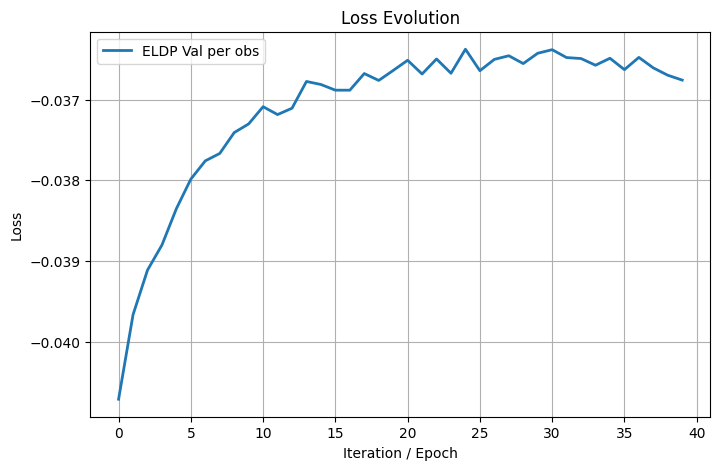

In [11]:
elbo= output['loss_history']
#loss_history = output['ll_history']
val_loss = output['val_history']



# Plot            
plt.figure(figsize=(8, 5))
plt.plot(val_loss, label="ELDP Val per obs", linewidth=2)
plt.xlabel("Iteration / Epoch")
plt.ylabel("Loss")
plt.title("Loss Evolution")
plt.legend()
plt.grid(True)
plt.show()

### 4. Compare to Benchmarks

We compare the learned GTM to a Gaussian Approximation and the Oracle Model. We expect the GTM to lie between these two in terms of approximation the true underlying distribution.
We measure this by means of the Kullback Leibler Divergence which we approximate on the test set which is equivalent to the log likelihood ratio between the true distribution and an approximation of it..

In [12]:
log_likelihood_train_bgtm = model.log_likelihood(simulated_data_train)
log_likelihood_validate_bgtm = model.log_likelihood(simulated_data_validate)
log_likelihood_test_bgtm = model.log_likelihood(simulated_data_test)


log_likelihood_train_gtm = model_freq.log_likelihood(simulated_data_train)
log_likelihood_validate_gtm = model_freq.log_likelihood(simulated_data_validate)
log_likelihood_test_gtm = model_freq.log_likelihood(simulated_data_test)

In [13]:
# estimate the Multivariate Normal Distribution as Model
mean_mvn_model = simulated_data_train.mean(0)
cov_mvn_model = simulated_data_train.T.cov()
mvn_model = torch.distributions.MultivariateNormal(loc=mean_mvn_model, covariance_matrix=cov_mvn_model)
log_likelihood_train_gaussian = (mvn_model.log_prob(simulated_data_train)).to(device)
log_likelihood_validate_gaussian = (mvn_model.log_prob(simulated_data_validate)).to(device)
log_likelihood_test_gaussian = (mvn_model.log_prob(simulated_data_test)).to(device)


In [14]:
print("KLD BGTM      Train Data: ",np.round(torch.mean(loglik_true_train - log_likelihood_train_bgtm).item(),4) )
print("KLD GTM      Train Data: ",np.round(torch.mean(loglik_true_train - log_likelihood_train_gtm).item(),4) )
print("KLD Gaussian Train Data: ",np.round(torch.mean(loglik_true_train - log_likelihood_train_gaussian).item(),4) )
print("KLD Copula   Train Data: ",np.round(torch.mean(loglik_true_train - loglik_true_est_train).item(),4) )
print("")
print("KLD BGTM      Test  Data: ",np.round(torch.mean(loglik_true_test - log_likelihood_test_bgtm).item(),4) )
print("KLD GTM      Test  Data: ",np.round(torch.mean(loglik_true_test - log_likelihood_test_gtm).item(),4) )
print("KLD Gaussian Test  Data: ",np.round(torch.mean(loglik_true_test - log_likelihood_test_gaussian).item(),4) )
print("KLD Copula   Test  Data: ",np.round(torch.mean(loglik_true_test - loglik_true_est_test).item(),4) )

KLD BGTM      Train Data:  0.0646
KLD GTM      Train Data:  0.0165
KLD Gaussian Train Data:  0.1144
KLD Copula   Train Data:  -0.0027

KLD BGTM      Test  Data:  0.0636
KLD GTM      Test  Data:  0.0216
KLD Gaussian Test  Data:  0.1159
KLD Copula   Test  Data:  0.0104


### 5. Evaluate and Plot GTM Results

We evaluate the model further by showing how to generate synthetic samples, plot the conditional correlation patterns as well as the model splines.

Note that to generate synthetic samples the inverse of the trainsformation layer needs to be approximated  with the method `approximate_transformation_inverse` once which is then stored for future sampling. 

In [15]:
model.approximate_transformation_inverse()
synthetic_samples = model.sample(10000)
model_freq.approximate_transformation_inverse()
synthetic_samples_freq = model_freq.sample(10000)

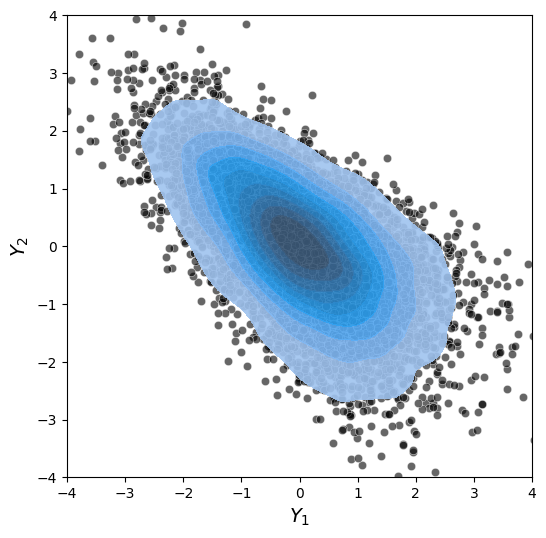

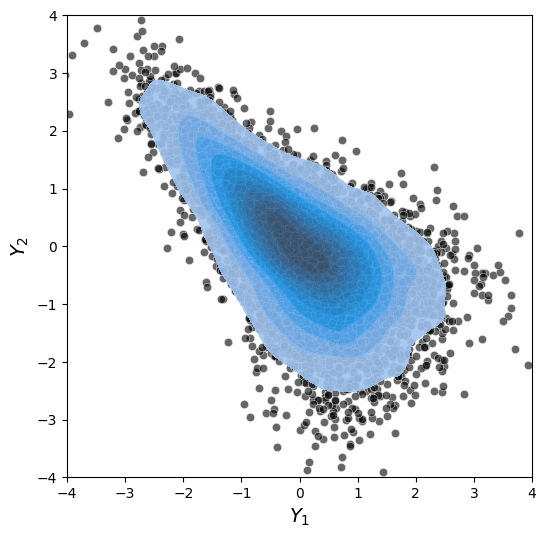

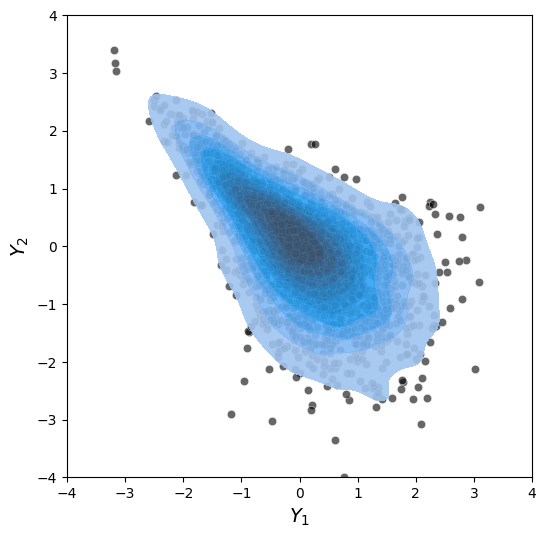

In [16]:
model.plot_densities(synthetic_samples.cpu(), x_lim=[-4,4], y_lim=[-4,4])
model_freq.plot_densities(synthetic_samples_freq.cpu(), x_lim=[-4,4], y_lim=[-4,4])
model.plot_densities(simulated_data_train.cpu(), x_lim=[-4,4], y_lim=[-4,4])

The varying pseudo conditional correlation matrix values can be computed for any synthetic samples using `compute_pseudo_conditional_correlation_matrix` or can directly be plotted using `plot_conditional_dependence_structure`.
The pseudo conditional correlation matrix is the standardised precision matrix so that off diagonal elements are the pseudo conditional correlations between the respective dimensions.

In [17]:
pseudo_conditional_correlation_matrix = model.compute_pseudo_conditional_correlation_matrix(synthetic_samples)

In [18]:
model.plot_conditional_dependence_structure(data=synthetic_samples.detach().cpu())

TypeError: can't convert cuda:0 device type tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory first.

One can also visualize the splines of each layer usign the function `plot_splines`. For the transformation layer we additionally include the dervaitive which is always positive due to the monotonically increasing constraint as well as the inverse which should lie exactly on the spline to visually confirm that the inverse sampling path works.

In [23]:
model.plot_splines(layer_type="transformation")

TypeError: expected TensorOptions(dtype=float, device=cpu, layout=Strided, requires_grad=false (default), pinned_memory=false (default), memory_format=(nullopt)) (got TensorOptions(dtype=float, device=cuda:0, layout=Strided, requires_grad=false (default), pinned_memory=false (default), memory_format=(nullopt)))

: 

: 

: 

/mnt/vast-standard/home/f.capunaycaceres/u22491/gtm/gtm/gtm_plots_analysis/plot_splines.py:250: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = results._append(


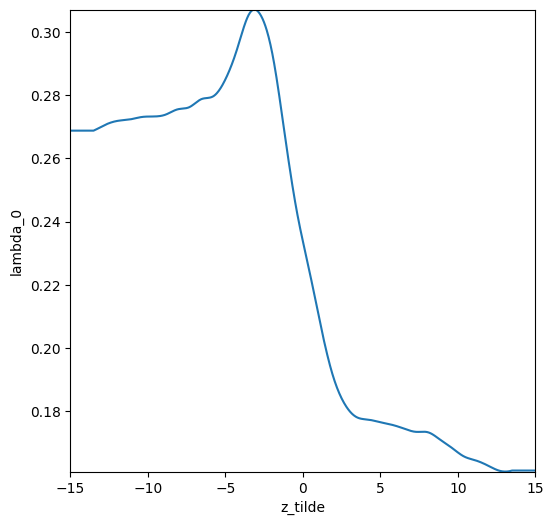

: 

: 

: 

In [ ]:
model.plot_splines(layer_type = "decorrelation", decorrelation_layer_number=0)

/mnt/vast-standard/home/f.capunaycaceres/u22491/gtm/gtm/gtm_plots_analysis/plot_splines.py:250: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = results._append(


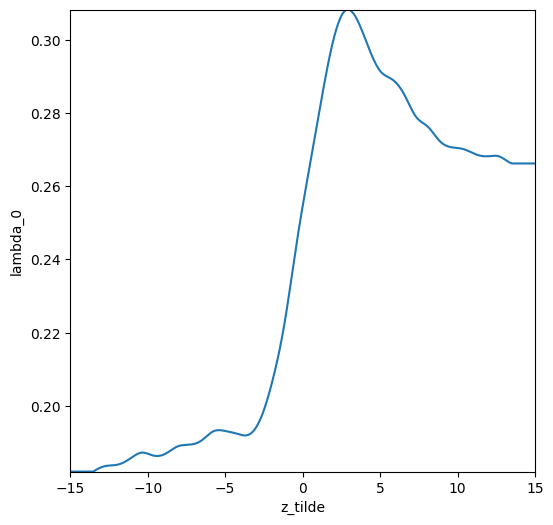

: 

: 

: 

In [ ]:
model.plot_splines(layer_type = "decorrelation", decorrelation_layer_number=1)

/mnt/vast-standard/home/f.capunaycaceres/u22491/gtm/gtm/gtm_plots_analysis/plot_splines.py:250: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = results._append(


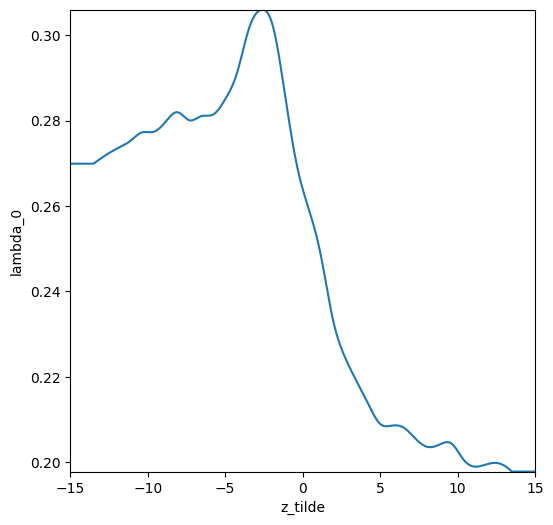

: 

: 

: 

In [ ]:
model.plot_splines(layer_type = "decorrelation", decorrelation_layer_number=2)